# PK/PD AL Model
# Date: 07/08/2025

## Checking model status, creating graphs for model validation and sensitivity analysis

<br>

In [1]:
import subprocess
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolacors
import pickle
from tqdm import tqdm  # For progress bar
from multiprocessing import Pool, cpu_count
import os
import sys
import time
import datetime 
from math import *

<br>

# ```pmax_artemether``` = 0.9998653531 and ```ec50_lum``` values for 4 genotypes

## AL maximum efficacy: 96.5%, 72.7892066535
## pfcrt K76: 92.5%, 121.5372211838
## pfcrt 76T: 91.9%, 129.4004601323
## pfmdr1 N86: 87.5%, 195.0108555496
## pfmdr1 86Y: 100%, 1.0000000000

<br>

<br>

## AL maximum efficacy: 96.5%, 
### ```pmax_artemether```: 0.9998653531
### ```ec50_lum```: 72.7892066535

In [2]:
# Function to run a single simulation for a given weight value

def run_single_weight_simulation(weight):
    start_time = time.monotonic()
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "5000",
        "--pmax_artemether", "0.9998653531",
        #"--pmax_artemether", "0.9999994",
        "--ec50_lum", "72.789",
        "--weight", str(weight)
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split() for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ARTEMETHER", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        if df_weight['PARASITEDENSITY'].isna().any():
            failed_treatment_count = np.nan
        else:
            failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0]
        
        total_patients = df_weight['PID'].nunique()
        
        if total_patients == 0 or np.isnan(failed_treatment_count): 
            efficacy = np.nan
        else:
            percentage_failed = (failed_treatment_count / total_patients) * 100
            efficacy = (100 - percentage_failed)
            if np.isnan(efficacy):
                efficacy = np.nan
        
        end_time = time.monotonic()
        today = datetime.date.today()
        print("\nToday's date: ", today, "\n")
        print("Length of simulation: ", datetime.timedelta(seconds=end_time - start_time), "\n")

        return efficacy, df_weight, failed_treatment_count
        
    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure

In [3]:
# Define the weight values to use
#weight_values = [5, 10, 15, 20, 30, 40, 50, 60, 70]
weight_values = [54]

# File suffix for saving results
file_suffix = "AL_max_efficacy"

for weight in weight_values:

        efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)
        
        # Save the DataFrame to a pickle file
        df_weight.to_pickle(f"df_weight_{weight}kg_{file_suffix}.pyobj")

        # Save the DataFrame to a CSV file
        df_weight.to_csv(f"df_weight_{weight}kg_{file_suffix}.csv", index=False)

        print(f"\nThe failed treatment count for weight {weight}kg is:", failed_treatment_count)
        print(f"\nThe percentage efficacy for weight {weight}kg is:", efficacy, "\n")



Today's date:  2025-07-08 

Length of simulation:  0:02:05.537287 


The failed treatment count for weight 54kg is: 175

The percentage efficacy for weight 54kg is: 96.5 



In [4]:
# Load the dataframes
# Calculate the efficacy for each weight group

failed_treatment_count = []
efficacy = []
df_weight_compiled = []

for weight in [54]:
    # Load the dataframe
    df_weight = pd.read_pickle(f"df_weight_{weight}kg_{file_suffix}.pyobj")
    # Calculate the efficacy
    failed_treatment_count.append(df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0])
    total_patients = df_weight['PID'].nunique()
    efficacy.append((1 - (failed_treatment_count[-1] / total_patients)) * 100 if total_patients > 0 else np.nan)
    # Append the dataframe to the list
    df_weight_compiled.append(df_weight)
# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Weight': [54],
    'Failed Treatment Count': failed_treatment_count,
    'Efficacy': efficacy
})

# Save the results to a CSV file
results_df.to_csv(f"efficacy_results_compiled_{file_suffix}.csv", index=False)
# Save the results to a pickle file
results_df.to_pickle(f"efficacy_results_compiled_{file_suffix}.pyobj")
# Print the results
print("\nEfficacy Results:")
print(results_df)
 


Efficacy Results:
   Weight  Failed Treatment Count  Efficacy
0      54                     175      96.5


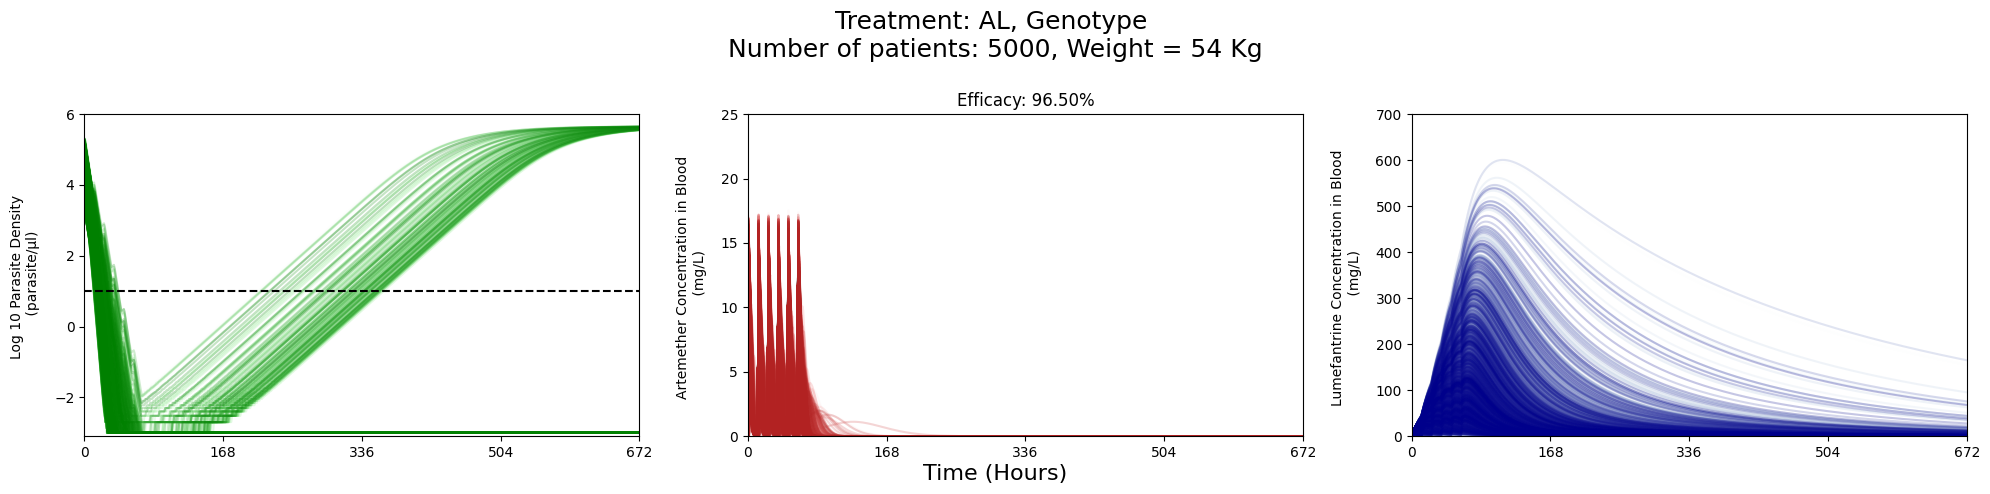

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

df_dict = {54: df_weight_compiled[0]}

fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharex=True)  # 3 rows, 1 column

# Define colormaps for each plot
green_cmap = LinearSegmentedColormap.from_list("green_cmap", ["white", "lightgreen", "green"])
red_cmap = LinearSegmentedColormap.from_list("red_cmap", ["white", "lightcoral", "firebrick"])
blue_cmap = LinearSegmentedColormap.from_list("blue_cmap", ["white", "lightsteelblue", "darkblue"])

weight = 54
df_weight = df_dict[weight]
num_pids = len(df_weight['PID'].unique())
norm = plt.Normalize(vmin=0, vmax=num_pids - 1)

# Log10 Parasite Density
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid].copy()
    df_pid['LOG10_PARASITEDENSITY'] = np.log10(df_pid['PARASITEDENSITY'] + 0.001)
    color = green_cmap(norm(j))
    ax[0].plot(df_pid['HOUR'], df_pid['LOG10_PARASITEDENSITY'], color=color, alpha=0.25)
ax[0].set_ylim(-3.1, 6)
ax[0].axhline(y=np.log10(10), color='black', linestyle='--')

# Artemether Concentration
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = red_cmap(norm(j))
    ax[1].plot(df_pid['HOUR'], df_pid['COMP2CONC_ARTEMETHER'], color=color, alpha=0.25)
ax[1].set_ylim(0, 25)
ax[1].set_yticks(range(0, 30, 5))

# Lumefantrine Concentration
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = blue_cmap(norm(j))
    ax[2].plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)
ax[2].set_ylim(0, 700)
ax[2].set_yticks(range(0, 800, 100))

# Set x-axis limits and ticks
for a in ax:
    a.set_xlim(0, 672)
    a.set_xticks(range(0, 673, 168))

# Set titles and labels
ax[1].set_title(f'Efficacy: {results_df[results_df["Weight"] == weight]["Efficacy"].values[0]:.2f}%')
row_titles = [
    "Log 10 Parasite Density \n (parasite/μl)",
    "Artemether Concentration in Blood \n (mg/L)",
    "Lumefantrine Concentration in Blood \n (mg/L)"
]
for i, a in enumerate(ax):
    a.set_ylabel(row_titles[i], fontsize=10, rotation=90, labelpad=10)

fig.text(0.5, 0.04, 'Time (Hours)', ha='center', fontsize=16)
#fig.suptitle(f"Treatment: AL, Genotype: TYY--C1 and TYY--C2\nNumber of patients: {num_pids} for each Weight Group", fontsize=18)
fig.suptitle(f"Treatment: AL, Genotype \nNumber of patients: {num_pids}, Weight = 54 Kg", fontsize=18)
plt.tight_layout(rect=[0, 0.05, 1, 0.98])
plt.savefig(f"df_weight_efficacy_{file_suffix}.png")
plt.show()

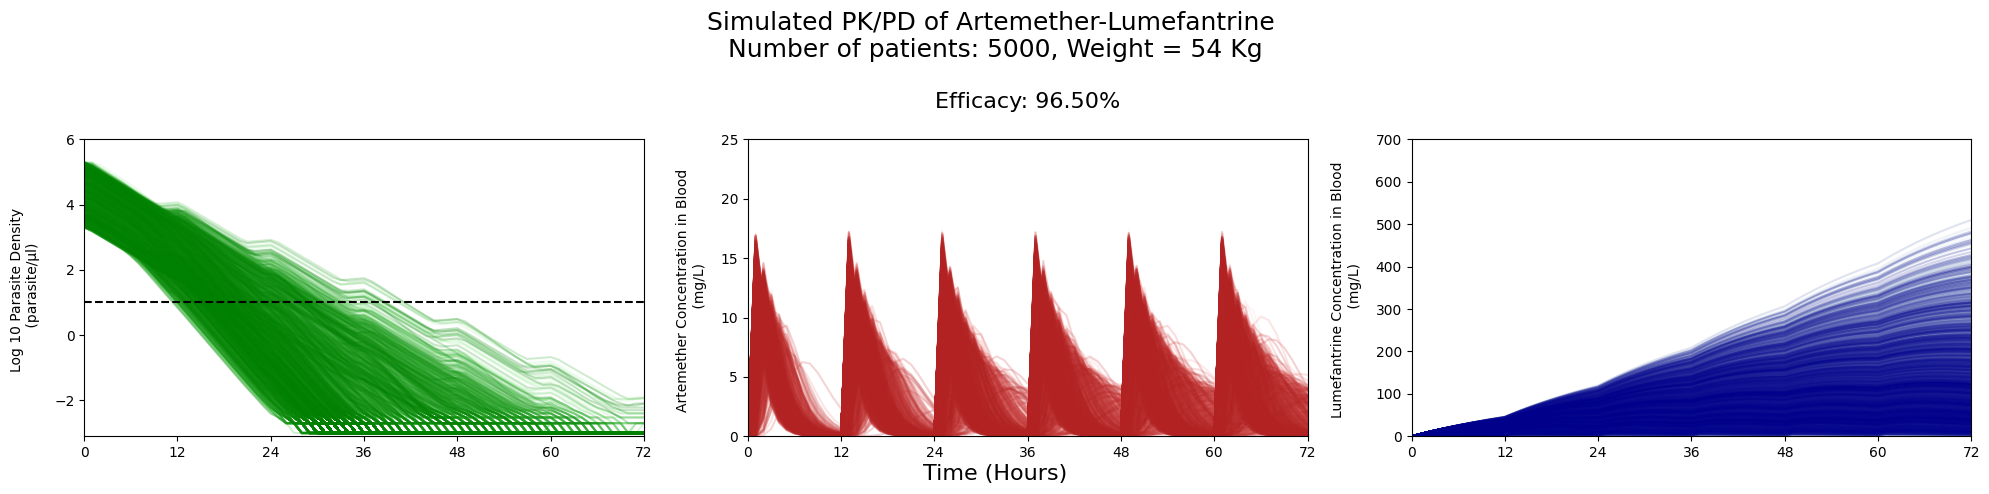

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

df_dict = {54: df_weight_compiled[0]}

fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharex=True)  # 3 rows, 1 column

# Define colormaps for each plot
green_cmap = LinearSegmentedColormap.from_list("green_cmap", ["white", "lightgreen", "green"])
red_cmap = LinearSegmentedColormap.from_list("red_cmap", ["white", "lightcoral", "firebrick"])
blue_cmap = LinearSegmentedColormap.from_list("blue_cmap", ["white", "lightsteelblue", "darkblue"])

weight = 54
df_weight = df_dict[weight]
num_pids = len(df_weight['PID'].unique())
norm = plt.Normalize(vmin=0, vmax=num_pids - 1)

# Log10 Parasite Density
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid].copy()
    df_pid['LOG10_PARASITEDENSITY'] = np.log10(df_pid['PARASITEDENSITY'] + 0.001)
    color = green_cmap(norm(j))
    ax[0].plot(df_pid['HOUR'], df_pid['LOG10_PARASITEDENSITY'], color=color, alpha=0.25)
ax[0].set_ylim(-3.1, 6)
ax[0].axhline(y=np.log10(10), color='black', linestyle='--')

# Artemether Concentration
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = red_cmap(norm(j))
    ax[1].plot(df_pid['HOUR'], df_pid['COMP2CONC_ARTEMETHER'], color=color, alpha=0.25)
ax[1].set_ylim(0, 25)
ax[1].set_yticks(range(0, 30, 5))

# Lumefantrine Concentration
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = blue_cmap(norm(j))
    ax[2].plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)
ax[2].set_ylim(0, 700)
ax[2].set_yticks(range(0, 800, 100))

# Set x-axis limits and ticks
for a in ax:
    a.set_xlim(0, 72)
    a.set_xticks(range(0, 73, 12))

# Set titles and labels
ax[1].set_title(f'Efficacy: {results_df[results_df["Weight"] == weight]["Efficacy"].values[0]:.2f}%\n', fontsize=16)
row_titles = [
    "Log 10 Parasite Density \n (parasite/μl)",
    "Artemether Concentration in Blood \n (mg/L)",
    "Lumefantrine Concentration in Blood \n (mg/L)"
]
for i, a in enumerate(ax):
    a.set_ylabel(row_titles[i], fontsize=10, rotation=90, labelpad=10)

fig.text(0.5, 0.04, 'Time (Hours)', ha='center', fontsize=16)
#fig.suptitle(f"Treatment: AL, Genotype: TYY--C1 and TYY--C2\nNumber of patients: {num_pids} for each Weight Group", fontsize=18)
fig.suptitle(f"Simulated PK/PD of Artemether-Lumefantrine \nNumber of patients: {num_pids}, Weight = 54 Kg", fontsize=18)
plt.tight_layout(rect=[0, 0.05, 1, 0.98])
plt.savefig(f"df_weight_efficacy_{file_suffix}.png")
plt.show()

In [ ]:
#Converting to pandas DataFrame
df_weight_compiled_pandas = df_weight_compiled[0].copy()
df_weight_compiled_pandas['LOG10_PARASITEDENSITY'] = np.log10(df_weight_compiled_pandas['PARASITEDENSITY'] + 0.001)

df_weight_compiled_failed = df_weight_compiled_pandas[(df_weight_compiled_pandas['PARASITEDENSITY'] >= 10) & (df_weight_compiled_pandas['HOUR'] == 671.0)]
df_weight_compiled_failed_pids = df_weight_compiled_failed['PID'].unique().tolist()

#Assigning patients as failred/cleared based on day 28 parasite density
df_weight_compiled_pandas['STATUS'] = np.where(df_weight_compiled_pandas['PID'].isin(df_weight_compiled_failed_pids), 'Failed', 'Cleared')
df_weight_compiled_pandas

In [19]:
#Separating patients into failed and cleared
df_weight_compiled_cleared = df_weight_compiled_pandas[df_weight_compiled_pandas['STATUS'] == 'Cleared']
df_weight_compiled_failed = df_weight_compiled_pandas[df_weight_compiled_pandas['STATUS'] == 'Failed']

#Saving the cleared and failed dataframes to csv files
df_weight_compiled_cleared.to_csv(f'{file_suffix}_cleared.csv', index=False, quoting= False)
df_weight_compiled_failed.to_csv(f'{file_suffix}_failed.csv', index=False, quoting= False)

In [30]:
df_weight_compiled_cleared_wide = df_weight_compiled_cleared.pivot(index="HOUR", columns="PID", values="PARASITEDENSITY")
#df_weight_compiled_cleared_wide

df_weight_compiled_cleared_wide_log = df_weight_compiled_cleared.pivot(index="HOUR", columns="PID", values="LOG10_PARASITEDENSITY")
#df_weight_compiled_cleared_wide_log

In [31]:
df_weight_compiled_failed_wide = df_weight_compiled_failed.pivot(index="HOUR", columns="PID", values="PARASITEDENSITY")
#df_weight_compiled_failed_wide

df_weight_compiled_failed_wide_log = df_weight_compiled_failed.pivot(index="HOUR", columns="PID", values="LOG10_PARASITEDENSITY")
#df_weight_compiled_failed_wide_log

In [43]:
# Calculate the median, 25th percentile, and 75th percentile for cleared and failed
median_parasite_density_cleared = df_weight_compiled_cleared_wide.median(axis=1)
perc_05_parasite_density_cleared = df_weight_compiled_cleared_wide.quantile(0.05,axis=1)
perc_25_parasite_density_cleared = df_weight_compiled_cleared_wide.quantile(0.25,axis=1)
perc_75_parasite_density_cleared = df_weight_compiled_cleared_wide.quantile(0.75,axis=1)
perc_95_parasite_density_cleared = df_weight_compiled_cleared_wide.quantile(0.95,axis=1)


median_parasite_density_failed = df_weight_compiled_failed_wide.median(axis=1)
perc_25_parasite_density_failed = df_weight_compiled_failed_wide.quantile(0.25,axis=1)
perc_75_parasite_density_failed = df_weight_compiled_failed_wide.quantile(0.75,axis=1)
perc_05_parasite_density_failed = df_weight_compiled_failed_wide.quantile(0.05,axis=1)
perc_95_parasite_density_failed = df_weight_compiled_failed_wide.quantile(0.95,axis=1)


# Calculate the median, 25th percentile, and 75th percentile for cleared and failed using log parasite density
median_parasite_density_cleared_log =  df_weight_compiled_cleared_wide_log.median(axis=1)
perc_25_parasite_density_cleared_log = df_weight_compiled_cleared_wide_log.quantile(0.25,axis=1)
perc_75_parasite_density_cleared_log = df_weight_compiled_cleared_wide_log.quantile(0.75,axis=1)
perc_05_parasite_density_cleared_log = df_weight_compiled_cleared_wide_log.quantile(0.05,axis=1)
perc_95_parasite_density_cleared_log = df_weight_compiled_cleared_wide_log.quantile(0.95,axis=1)

median_parasite_density_failed_log = df_weight_compiled_failed_wide_log.median(axis=1)
perc_25_parasite_density_failed_log = df_weight_compiled_failed_wide_log.quantile(0.25,axis=1)
perc_75_parasite_density_failed_log = df_weight_compiled_failed_wide_log.quantile(0.75,axis=1)
perc_05_parasite_density_failed_log = df_weight_compiled_failed_wide_log.quantile(0.05,axis=1)
perc_95_parasite_density_failed_log = df_weight_compiled_failed_wide_log.quantile(0.95,axis=1)


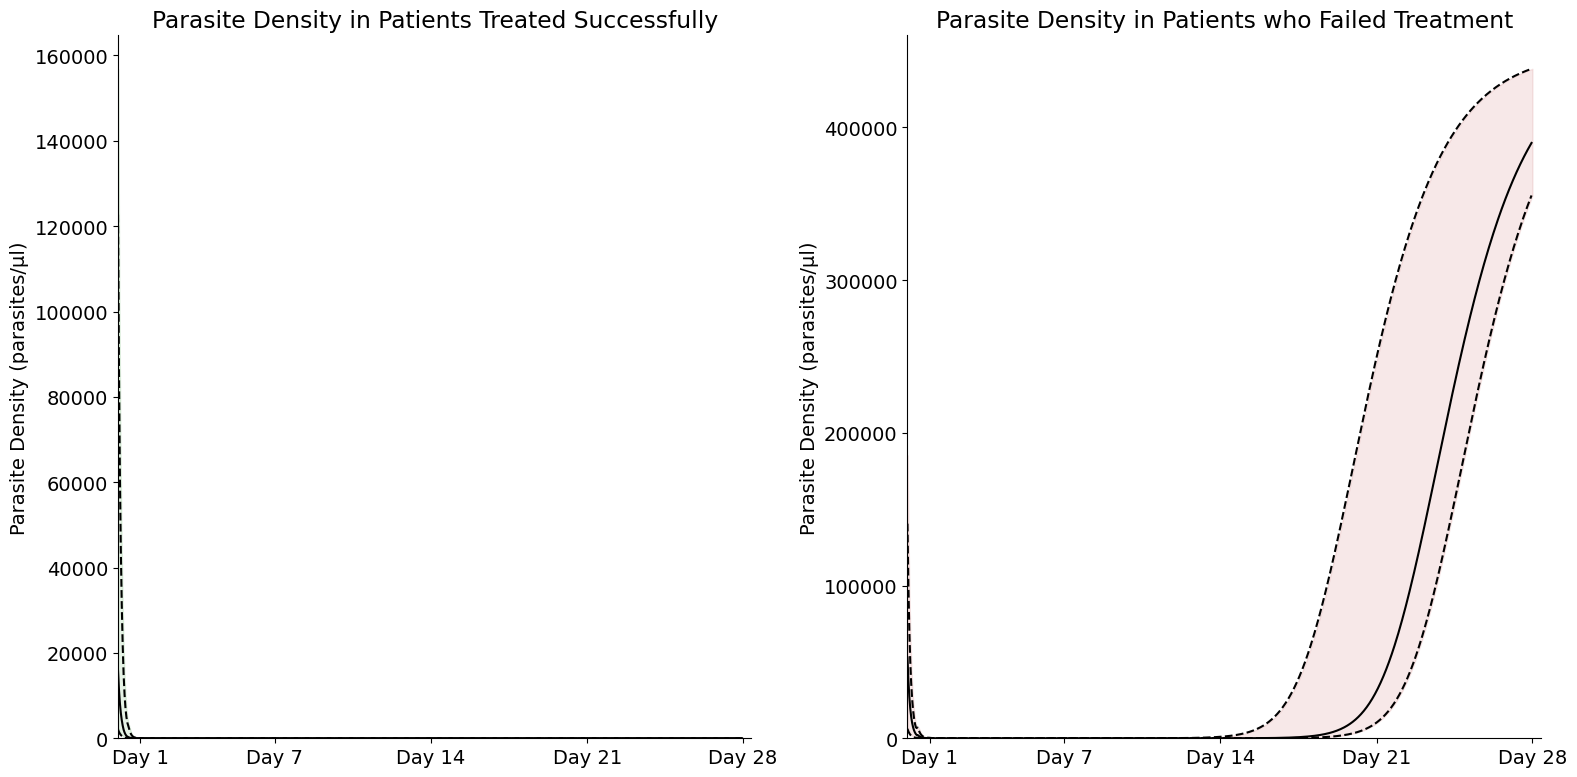

In [45]:
import seaborn as sns

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

colors = ["#B22222", "#98FF98"]
sns.set_palette(sns.color_palette(colors))

ax1 = sns.lineplot(ax=axes[0], x= df_weight_compiled_pandas['HOUR'], y= median_parasite_density_cleared, color="black")
sns.lineplot(ax=axes[0], x=df_weight_compiled_pandas['HOUR'], y=perc_05_parasite_density_cleared, color="black", linestyle='--')
sns.lineplot(ax=axes[0], x=df_weight_compiled_pandas['HOUR'], y=perc_95_parasite_density_cleared, color="black", linestyle='--')
axes[0].fill_between(np.arange(672),perc_05_parasite_density_cleared, perc_95_parasite_density_cleared, color="#008400", alpha=0.1)

sns.despine(ax=ax1)


ax1.set_xlim(0, 680)
#ax1.set_yticks(range(0, int(df_100_patients['PARASITEDENSITY'].max()) + 100, 1000))
ax1.set_ylim(0)
#Set x-axis label
ax1.set_xlabel('')
#Set y-axis label
ax1.set_ylabel('Parasite Density (parasites/μl)')

# Set tick positions and labels for specific days
tick_positions = [24.0,168.0, 336.0, 504.0,671.0]  # Day 0, Day 7, Day 14, Day 28 in hours
tick_labels = ['Day 1', 'Day 7', 'Day 14', 'Day 21','Day 28']
ax1.set_xticks(tick_positions, tick_labels)

#Plot title
ax1.set_title('Parasite Density in Patients Treated Successfully')


ax2 = sns.lineplot(ax=axes[1], x= df_weight_compiled_pandas['HOUR'], y= median_parasite_density_failed, color="black")
sns.lineplot(ax=axes[1], x=df_weight_compiled_pandas['HOUR'], y=perc_05_parasite_density_failed, color="black", linestyle='--')
sns.lineplot(ax=axes[1], x=df_weight_compiled_pandas['HOUR'], y=perc_95_parasite_density_failed, color="black", linestyle='--')
axes[1].fill_between(np.arange(672), perc_05_parasite_density_failed, perc_95_parasite_density_failed, color="#B22222", alpha=0.1)

sns.despine(ax=ax2)

ax2.set_xlim(0, 680)
ax2.set_ylim(0)
#Set x-axis label
ax2.set_xlabel('')
#Set y-axis label
ax2.set_ylabel('Parasite Density (parasites/μl)')
ax2.set_xticks(tick_positions)
ax2.set_xticklabels(tick_labels)
#Plot title
ax2.set_title('Parasite Density in Patients who Failed Treatment')


plt.savefig(f'{file_suffix}_parasite_density.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [52]:
median_parasite_density_failed_log

HOUR
0.0      4.832304
1.0      4.724282
2.0      4.578460
3.0      4.433870
4.0      4.290272
           ...   
667.0    5.585982
668.0    5.587228
669.0    5.588452
670.0    5.589653
671.0    5.590832
Length: 672, dtype: float64

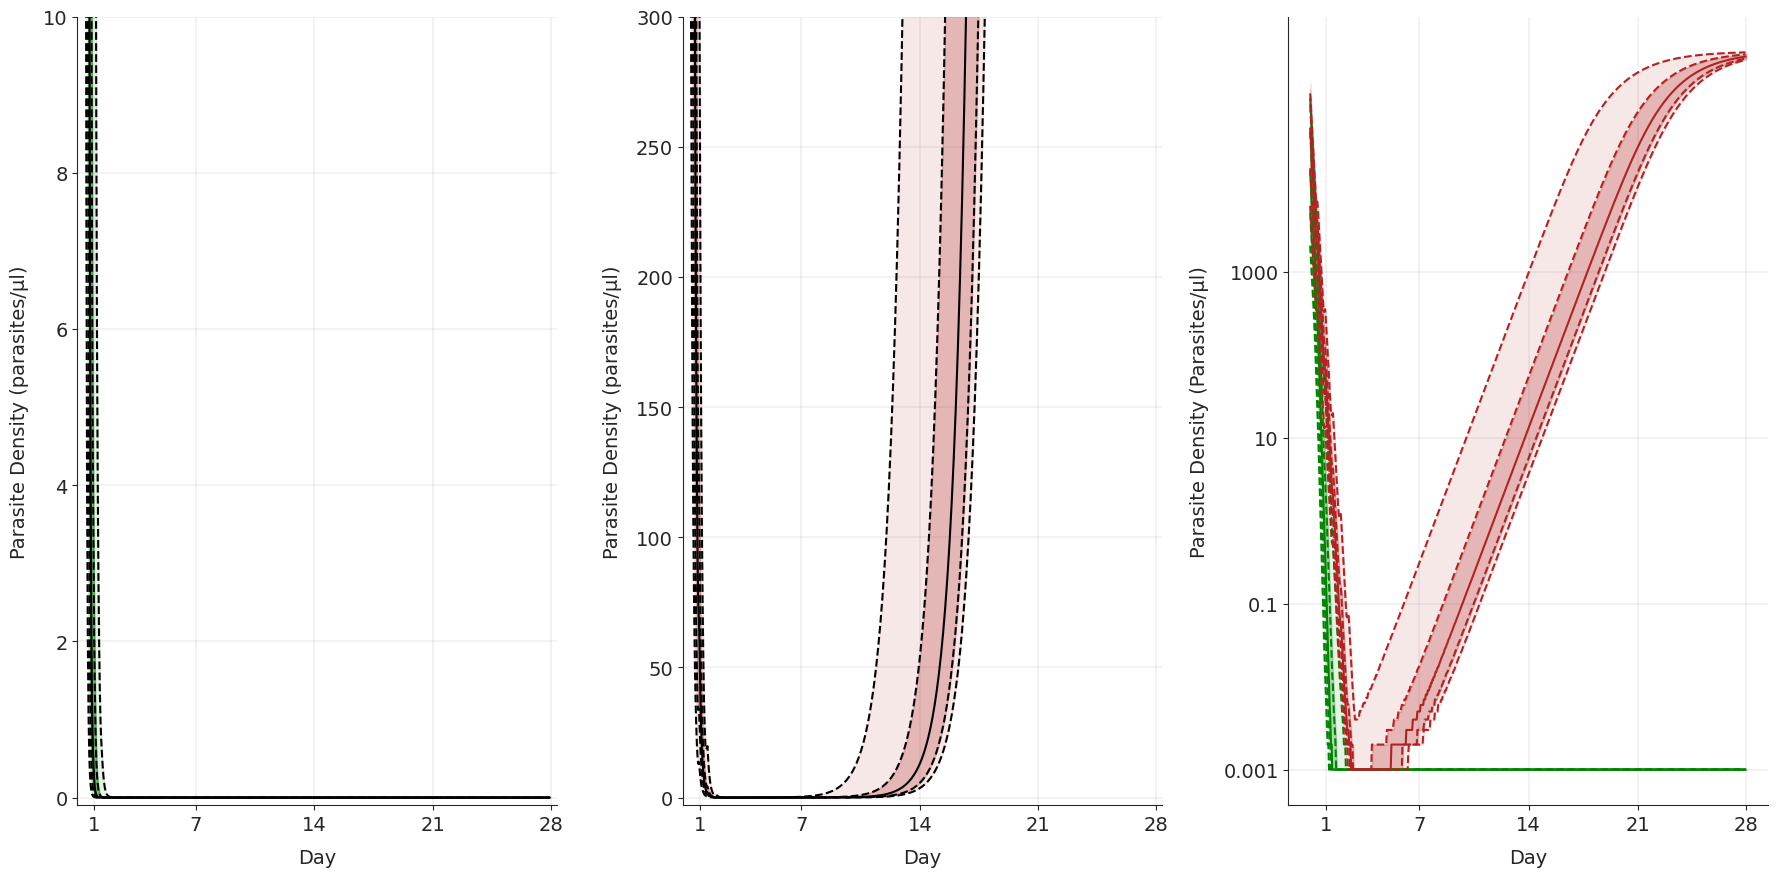

In [49]:
# Create subplots
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(1, 3, figsize=(18, 9))

colors = ["#B22222", "#98FF98"]
sns.set_palette(sns.color_palette(colors))

ax1 = sns.lineplot(ax=axes[0], x= df_weight_compiled_pandas['HOUR'], y= median_parasite_density_cleared, color="black")
sns.lineplot(ax=axes[0], x=df_weight_compiled_pandas['HOUR'], y=perc_05_parasite_density_cleared, color="black", linestyle='--')
sns.lineplot(ax=axes[0], x=df_weight_compiled_pandas['HOUR'], y=perc_25_parasite_density_cleared, color="black", linestyle='--')
sns.lineplot(ax=axes[0], x=df_weight_compiled_pandas['HOUR'], y=perc_75_parasite_density_cleared, color="black", linestyle='--')
sns.lineplot(ax=axes[0], x=df_weight_compiled_pandas['HOUR'], y=perc_95_parasite_density_cleared, color="black", linestyle='--')
axes[0].fill_between(np.arange(672),perc_25_parasite_density_cleared, perc_75_parasite_density_cleared, color="#008400", alpha=0.5)
axes[0].fill_between(np.arange(672),perc_05_parasite_density_cleared, perc_95_parasite_density_cleared, color="#008400", alpha=0.1)


sns.despine(ax=ax1)


ax1.set_xlim(0, 680)
#ax1.set_yticks(range(0, int(df_100_patients['PARASITEDENSITY'].max()) + 100, 1000))
ax1.set_ylim(-0.1, 10)
#Set x-axis label
ax1.set_xlabel('Day', labelpad = 10)
#Set y-axis label
ax1.set_ylabel('Parasite Density (parasites/μl)', labelpad = 10)

# Set tick positions and labels for specific days
tick_positions = [24.0,168.0, 336.0, 504.0,671.0]  # Day 0, Day 7, Day 14, Day 28 in hours
tick_labels = ['1', '7', '14', '21','28']
ax1.set_xticks(tick_positions, tick_labels)
#Adding grid lines
axes[0].grid(visible=True, which='major', color='black', linewidth=0.075)
axes[0].grid(visible=True, which='minor', color='black', linewidth=0.075)
#Plot title
#ax1.set_title('Parasite Density in Patients Treated Successfully', fontsize = 10, pad = 20)


ax2 = sns.lineplot(ax=axes[1], x= df_weight_compiled_pandas['HOUR'], y= median_parasite_density_failed, color="black")
sns.lineplot(ax=axes[1], x=df_weight_compiled_pandas['HOUR'], y=perc_05_parasite_density_failed, color="black", linestyle='--')
sns.lineplot(ax=axes[1], x=df_weight_compiled_pandas['HOUR'], y=perc_25_parasite_density_failed, color="black", linestyle='--')
sns.lineplot(ax=axes[1], x=df_weight_compiled_pandas['HOUR'], y=perc_75_parasite_density_failed, color="black", linestyle='--')
sns.lineplot(ax=axes[1], x=df_weight_compiled_pandas['HOUR'], y=perc_95_parasite_density_failed, color="black", linestyle='--')
axes[1].fill_between(np.arange(672), perc_05_parasite_density_failed, perc_95_parasite_density_failed, color="#B22222", alpha=0.1)
axes[1].fill_between(np.arange(672),perc_25_parasite_density_failed, perc_75_parasite_density_failed, color="#B22222", alpha=0.25)   


sns.despine(ax=ax2)

ax2.set_xlim(0, 680)
ax2.set_ylim(-3, 300)
#Set x-axis label
ax2.set_xlabel('Day', labelpad = 10)
#Set y-axis label
ax2.set_ylabel('Parasite Density (parasites/μl)', labelpad = 10)
ax2.set_xticks(tick_positions)
ax2.set_xticklabels(tick_labels)
#Adding grid lines 
axes[1].grid(visible=True, which='major', color='black', linewidth=0.075)
axes[1].grid(visible=True, which='minor', color='black', linewidth=0.075)
#Plot title
#ax2.set_title('Parasite Density in Patients Treated Successfully', fontsize = 10, pad = 20)
#ax2.text(7, 299, 'Parasite Density in Patients with Treatment Failure', fontsize = 10)


sns.set_style("ticks")

palette_cleared = ["#e5ffe5","#cbffcb","#b2ffb2","#98FF98","#7fff7f","#65ff65","#4cff4c"]
palette_failed = ["#ffcbcb","#ff9797","#ff6464","#ff3232","#ff0000","#cb0000","#970000"] 
#sns.lineplot(x='HOUR', y='LOG_PARASITEDENSITY', hue='PID', palette=sns.color_palette(palette_cleared, 83), data=df_100_patients_cleared, legend=False)
#sns.lineplot(x='HOUR', y='LOG_PARASITEDENSITY', hue='PID', palette=sns.color_palette(palette_failed, 17), data=df_100_patients_failed, legend=False)

ax3 = sns.lineplot(ax = axes[2], x= df_weight_compiled_pandas['HOUR'], y= median_parasite_density_cleared_log, color="#008400")
sns.lineplot(ax = axes[2], x=df_weight_compiled_pandas['HOUR'], y=perc_05_parasite_density_cleared_log, color="#008400", linestyle='--')
sns.lineplot(ax = axes[2], x=df_weight_compiled_pandas['HOUR'], y=perc_25_parasite_density_cleared_log, color="#008400", linestyle='--')
sns.lineplot(ax = axes[2], x=df_weight_compiled_pandas['HOUR'], y=perc_75_parasite_density_cleared_log, color="#008400", linestyle='--')
sns.lineplot(ax = axes[2], x=df_weight_compiled_pandas['HOUR'], y=perc_95_parasite_density_cleared_log, color="#008400", linestyle='--')
axes[2].fill_between(np.arange(672),perc_05_parasite_density_cleared_log, perc_95_parasite_density_cleared_log, color="#008400", alpha=0.1)
axes[2].fill_between(np.arange(672),perc_25_parasite_density_cleared_log, perc_75_parasite_density_cleared_log, color="#008400", alpha=0.25)


sns.lineplot(ax = axes[2], x= df_weight_compiled_pandas['HOUR'], y= median_parasite_density_failed_log, color="#B22222")
sns.lineplot(ax = axes[2], x=df_weight_compiled_pandas['HOUR'], y=perc_05_parasite_density_failed_log, color="#B22222", linestyle='--')
sns.lineplot(ax = axes[2], x=df_weight_compiled_pandas['HOUR'], y=perc_25_parasite_density_failed_log, color="#B22222", linestyle='--')
sns.lineplot(ax = axes[2], x=df_weight_compiled_pandas['HOUR'], y=perc_75_parasite_density_failed_log, color="#B22222", linestyle='--')
sns.lineplot(ax = axes[2], x=df_weight_compiled_pandas['HOUR'], y=perc_95_parasite_density_failed_log, color="#B22222", linestyle='--')
axes[2].fill_between(np.arange(672),perc_05_parasite_density_failed_log, perc_95_parasite_density_failed_log, color="#B22222", alpha=0.1)
axes[2].fill_between(np.arange(672),perc_25_parasite_density_failed_log, perc_75_parasite_density_failed_log, color="#B22222", alpha=0.25)


sns.despine()

#Adding grid lines
axes[2].grid(visible=True, which='major', color='black', linewidth=0.075)
axes[2].grid(visible=True, which='minor', color='black', linewidth=0.075)

# Set tick positions and labels for specific days
tick_positions = [24.0, 168.0, 336.0, 504.0,671.0]  # Day 0, Day 7, Day 14, Day 28 in hours
tick_labels = ['1', '7', '14', '21','28']
ax3.set_xticks(tick_positions, tick_labels)

tick_positions_yaxis = [-3, -1, 1, 3]
tick_labels_yaxis = [0.001, 0.1, 10, 1000]
ax3.set_yticks(tick_positions_yaxis, tick_labels_yaxis)

ax3.set_xlabel('Day', labelpad = 10)
ax3.set_ylabel('Parasite Density (Parasites/μl)', labelpad = 10)
#ax3.set_title('Log10 Parasite Density in all Patients', fontsize = 10, pad = 20)

# Set common x-axis label
#fig.text(0.5, 0.04, 'Day', ha='center', va='center')

#Save plot
#plt.savefig('final_plots.svg', format='svg', )

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

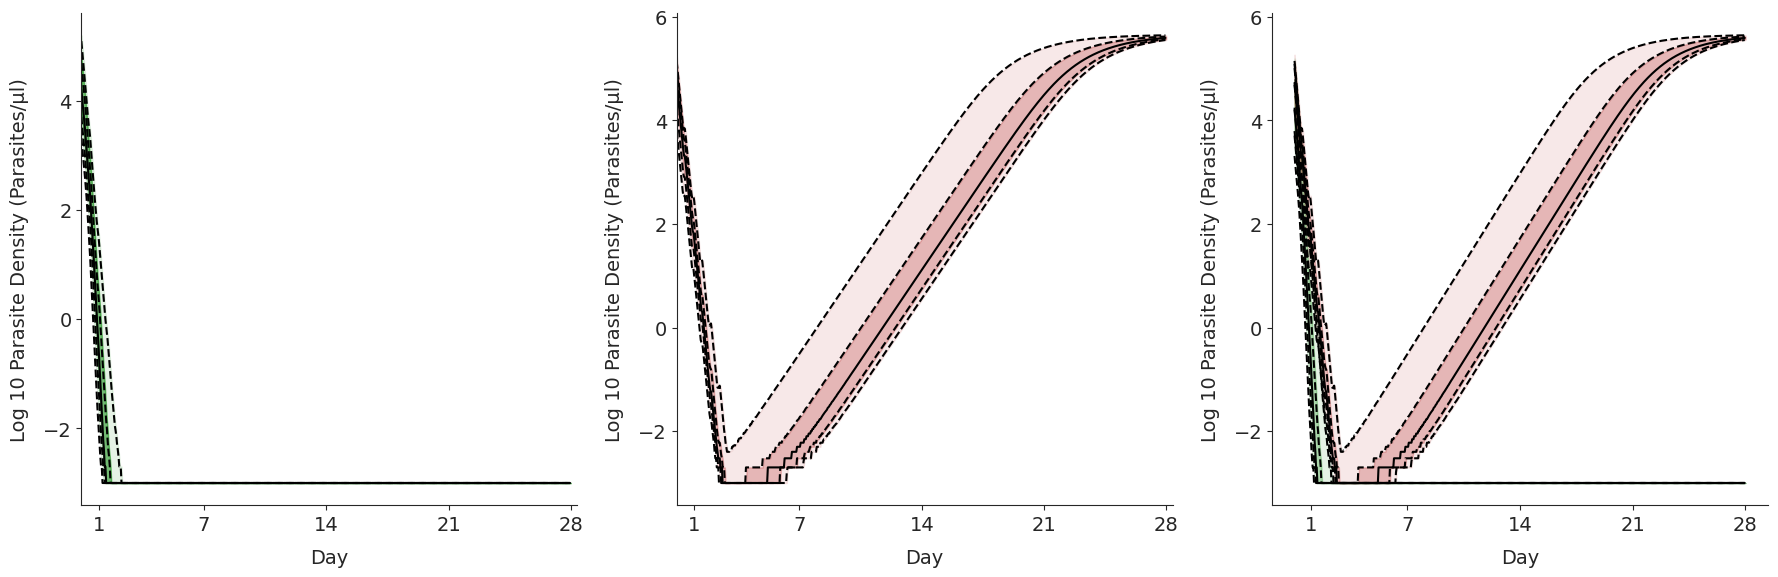

In [63]:
# Create subplots
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

colors = ["#B22222", "#98FF98"]
sns.set_palette(sns.color_palette(colors))

ax1 = sns.lineplot(ax=axes[0], x= df_weight_compiled_pandas['HOUR'], y= median_parasite_density_cleared_log, color="black")
sns.lineplot(ax=axes[0], x=df_weight_compiled_pandas['HOUR'], y=perc_05_parasite_density_cleared_log, color="black", linestyle='--')
sns.lineplot(ax=axes[0], x=df_weight_compiled_pandas['HOUR'], y=perc_25_parasite_density_cleared_log, color="black", linestyle='--')
sns.lineplot(ax=axes[0], x=df_weight_compiled_pandas['HOUR'], y=perc_75_parasite_density_cleared_log, color="black", linestyle='--')
sns.lineplot(ax=axes[0], x=df_weight_compiled_pandas['HOUR'], y=perc_95_parasite_density_cleared_log, color="black", linestyle='--')
axes[0].fill_between(np.arange(672),perc_25_parasite_density_cleared_log, perc_75_parasite_density_cleared_log, color="#008400", alpha=0.5)
axes[0].fill_between(np.arange(672),perc_05_parasite_density_cleared_log, perc_95_parasite_density_cleared_log, color="#008400", alpha=0.1)


sns.despine(ax=ax1)


ax1.set_xlim(0, 680)
#ax1.set_yticks(range(0, int(df_100_patients['PARASITEDENSITY'].max()) + 100, 1000))
#ax1.set_ylim(-0.1, 10)
#Set x-axis label
ax1.set_xlabel('Day', labelpad = 10)
#Set y-axis label
ax1.set_ylabel('Log 10 Parasite Density (Parasites/μl)', labelpad = 10)

# Set tick positions and labels for specific days
tick_positions = [24.0,168.0, 336.0, 504.0,671.0]  # Day 0, Day 7, Day 14, Day 28 in hours
tick_labels = ['1', '7', '14', '21','28']
ax1.set_xticks(tick_positions, tick_labels)
#Adding grid lines
# axes[0].grid(visible=True, which='major', color='black', linewidth=0.075)
# axes[0].grid(visible=True, which='minor', color='black', linewidth=0.075)
#Plot title
#ax1.set_title('Parasite Density in Patients Treated Successfully', fontsize = 10, pad = 20)


ax2 = sns.lineplot(ax=axes[1], x= df_weight_compiled_pandas['HOUR'], y= median_parasite_density_failed_log, color="black")
sns.lineplot(ax=axes[1], x=df_weight_compiled_pandas['HOUR'], y=perc_05_parasite_density_failed_log, color="black", linestyle='--')
sns.lineplot(ax=axes[1], x=df_weight_compiled_pandas['HOUR'], y=perc_25_parasite_density_failed_log, color="black", linestyle='--')
sns.lineplot(ax=axes[1], x=df_weight_compiled_pandas['HOUR'], y=perc_75_parasite_density_failed_log, color="black", linestyle='--')
sns.lineplot(ax=axes[1], x=df_weight_compiled_pandas['HOUR'], y=perc_95_parasite_density_failed_log, color="black", linestyle='--')
axes[1].fill_between(np.arange(672), perc_05_parasite_density_failed_log, perc_95_parasite_density_failed_log, color="#B22222", alpha=0.1)
axes[1].fill_between(np.arange(672),perc_25_parasite_density_failed_log, perc_75_parasite_density_failed_log, color="#B22222", alpha=0.25)   


sns.despine(ax=ax2)

ax2.set_xlim(0, 680)
#ax2.set_ylim(-3, 300)
#Set x-axis label
ax2.set_xlabel('Day', labelpad = 10)
#Set y-axis label
ax2.set_ylabel('Log 10 Parasite Density (Parasites/μl)', labelpad = 10)
ax2.set_xticks(tick_positions)
ax2.set_xticklabels(tick_labels)
#Adding grid lines 
# axes[1].grid(visible=True, which='major', color='black', linewidth=0.075)
# axes[1].grid(visible=True, which='minor', color='black', linewidth=0.075)
#Plot title
#ax2.set_title('Parasite Density in Patients Treated Successfully', fontsize = 10, pad = 20)
#ax2.text(7, 299, 'Parasite Density in Patients with Treatment Failure', fontsize = 10)


sns.set_style("ticks")

palette_cleared = ["#e5ffe5","#cbffcb","#b2ffb2","#98FF98","#7fff7f","#65ff65","#4cff4c"]
palette_failed = ["#ffcbcb","#ff9797","#ff6464","#ff3232","#ff0000","#cb0000","#970000"] 
#sns.lineplot(x='HOUR', y='LOG_PARASITEDENSITY', hue='PID', palette=sns.color_palette(palette_cleared, 83), data=df_100_patients_cleared, legend=False)
#sns.lineplot(x='HOUR', y='LOG_PARASITEDENSITY', hue='PID', palette=sns.color_palette(palette_failed, 17), data=df_100_patients_failed, legend=False)

ax3 = sns.lineplot(ax = axes[2], x= df_weight_compiled_pandas['HOUR'], y= median_parasite_density_cleared_log, color="black")
sns.lineplot(ax = axes[2], x=df_weight_compiled_pandas['HOUR'], y=perc_05_parasite_density_cleared_log, color="black", linestyle='--')
sns.lineplot(ax = axes[2], x=df_weight_compiled_pandas['HOUR'], y=perc_25_parasite_density_cleared_log, color="black", linestyle='--')
sns.lineplot(ax = axes[2], x=df_weight_compiled_pandas['HOUR'], y=perc_75_parasite_density_cleared_log, color="black", linestyle='--')
sns.lineplot(ax = axes[2], x=df_weight_compiled_pandas['HOUR'], y=perc_95_parasite_density_cleared_log, color="black", linestyle='--')
axes[2].fill_between(np.arange(672),perc_05_parasite_density_cleared_log, perc_95_parasite_density_cleared_log, color="#008400", alpha=0.1)
axes[2].fill_between(np.arange(672),perc_25_parasite_density_cleared_log, perc_75_parasite_density_cleared_log, color="#008400", alpha=0.25)


sns.lineplot(ax = axes[2], x= df_weight_compiled_pandas['HOUR'], y= median_parasite_density_failed_log, color="black")
sns.lineplot(ax = axes[2], x=df_weight_compiled_pandas['HOUR'], y=perc_05_parasite_density_failed_log, color="black", linestyle='--')
sns.lineplot(ax = axes[2], x=df_weight_compiled_pandas['HOUR'], y=perc_25_parasite_density_failed_log, color="black", linestyle='--')
sns.lineplot(ax = axes[2], x=df_weight_compiled_pandas['HOUR'], y=perc_75_parasite_density_failed_log, color="black", linestyle='--')
sns.lineplot(ax = axes[2], x=df_weight_compiled_pandas['HOUR'], y=perc_95_parasite_density_failed_log, color="black", linestyle='--')
axes[2].fill_between(np.arange(672),perc_05_parasite_density_failed_log, perc_95_parasite_density_failed_log, color="#B22222", alpha=0.1)
axes[2].fill_between(np.arange(672),perc_25_parasite_density_failed_log, perc_75_parasite_density_failed_log, color="#B22222", alpha=0.25)


sns.despine()

#Adding grid lines
# axes[2].grid(visible=True, which='major', color='black', linewidth=0.075)
# axes[2].grid(visible=True, which='minor', color='black', linewidth=0.075)

# Set tick positions and labels for specific days
tick_positions = [24.0, 168.0, 336.0, 504.0,671.0]  # Day 0, Day 7, Day 14, Day 28 in hours
tick_labels = ['1', '7', '14', '21','28']
ax3.set_xticks(tick_positions, tick_labels)

#tick_positions_yaxis = [-3, -1, 1, 3]
#tick_labels_yaxis = [0.001, 0.1, 10, 1000]
#ax3.set_yticks(tick_positions_yaxis, tick_labels_yaxis)

ax3.set_xlabel('Day', labelpad = 10)
ax3.set_ylabel('Log 10 Parasite Density (Parasites/μl)', labelpad = 10)
#ax3.set_title('Log10 Parasite Density in all Patients', fontsize = 10, pad = 20)

# Set common x-axis label
#fig.text(0.5, 0.04, 'Day', ha='center', va='center')

#Save plot
plt.savefig(f'{file_suffix}_log_01.svg', format='svg', )

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

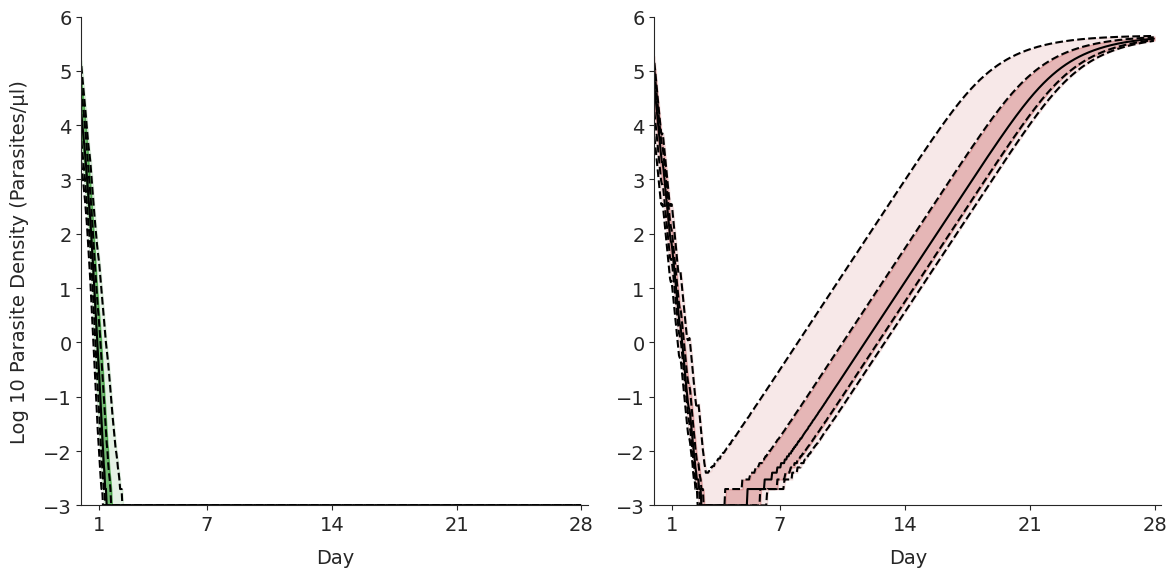

In [76]:
# Create subplots
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

colors = ["#B22222", "#98FF98"]
sns.set_palette(sns.color_palette(colors))

ax1 = sns.lineplot(ax=axes[0], x= df_weight_compiled_pandas['HOUR'], y= median_parasite_density_cleared_log, color="black")
sns.lineplot(ax=axes[0], x=df_weight_compiled_pandas['HOUR'], y=perc_05_parasite_density_cleared_log, color="black", linestyle='--')
sns.lineplot(ax=axes[0], x=df_weight_compiled_pandas['HOUR'], y=perc_25_parasite_density_cleared_log, color="black", linestyle='--')
sns.lineplot(ax=axes[0], x=df_weight_compiled_pandas['HOUR'], y=perc_75_parasite_density_cleared_log, color="black", linestyle='--')
sns.lineplot(ax=axes[0], x=df_weight_compiled_pandas['HOUR'], y=perc_95_parasite_density_cleared_log, color="black", linestyle='--')
axes[0].fill_between(np.arange(672),perc_25_parasite_density_cleared_log, perc_75_parasite_density_cleared_log, color="#008400", alpha=0.5)
axes[0].fill_between(np.arange(672),perc_05_parasite_density_cleared_log, perc_95_parasite_density_cleared_log, color="#008400", alpha=0.1)


sns.despine(ax=ax1)


ax1.set_xlim(0, 680)
#ax1.set_yticks(range(0, int(df_100_patients['PARASITEDENSITY'].max()) + 100, 1000))
ax1.set_ylim(-3, 6)
#Set x-axis label
ax1.set_xlabel('Day', labelpad = 10)
#Set y-axis label
ax1.set_ylabel('Log 10 Parasite Density (Parasites/μl)', labelpad = 10)

# Set tick positions and labels for specific days
tick_positions = [24.0,168.0, 336.0, 504.0,671.0]  # Day 0, Day 7, Day 14, Day 28 in hours
tick_labels = ['1', '7', '14', '21','28']
ax1.set_xticks(tick_positions, tick_labels)
#Adding grid lines
# axes[0].grid(visible=True, which='major', color='black', linewidth=0.075)
# axes[0].grid(visible=True, which='minor', color='black', linewidth=0.075)
#Plot title
#ax1.set_title('Parasite Density in Patients Treated Successfully', fontsize = 10, pad = 20)


ax2 = sns.lineplot(ax=axes[1], x= df_weight_compiled_pandas['HOUR'], y= median_parasite_density_failed_log, color="black")
sns.lineplot(ax=axes[1], x=df_weight_compiled_pandas['HOUR'], y=perc_05_parasite_density_failed_log, color="black", linestyle='--')
sns.lineplot(ax=axes[1], x=df_weight_compiled_pandas['HOUR'], y=perc_25_parasite_density_failed_log, color="black", linestyle='--')
sns.lineplot(ax=axes[1], x=df_weight_compiled_pandas['HOUR'], y=perc_75_parasite_density_failed_log, color="black", linestyle='--')
sns.lineplot(ax=axes[1], x=df_weight_compiled_pandas['HOUR'], y=perc_95_parasite_density_failed_log, color="black", linestyle='--')
axes[1].fill_between(np.arange(672), perc_05_parasite_density_failed_log, perc_95_parasite_density_failed_log, color="#B22222", alpha=0.1)
axes[1].fill_between(np.arange(672),perc_25_parasite_density_failed_log, perc_75_parasite_density_failed_log, color="#B22222", alpha=0.25)   


sns.despine(ax=ax2)

ax2.set_xlim(0, 680)
ax2.set_ylim(-3, 6)
#Set x-axis label
ax2.set_xlabel('Day', labelpad = 10)
#Set y-axis label
ax2.set_ylabel(None)
ax2.set_xticks(tick_positions)
ax2.set_xticklabels(tick_labels)
#Adding grid lines 
# axes[1].grid(visible=True, which='major', color='black', linewidth=0.075)
# axes[1].grid(visible=True, which='minor', color='black', linewidth=0.075)
#Plot title
#ax2.set_title('Parasite Density in Patients Treated Successfully', fontsize = 10, pad = 20)
#ax2.text(7, 299, 'Parasite Density in Patients with Treatment Failure', fontsize = 10)




#Adding grid lines
# axes[2].grid(visible=True, which='major', color='black', linewidth=0.075)
# axes[2].grid(visible=True, which='minor', color='black', linewidth=0.075)

# Set common x-axis label
#fig.text(0.5, 0.04, 'Day', ha='center', va='center')

#Save plot
plt.savefig(f'{file_suffix}_log_02.svg', format='svg', )

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

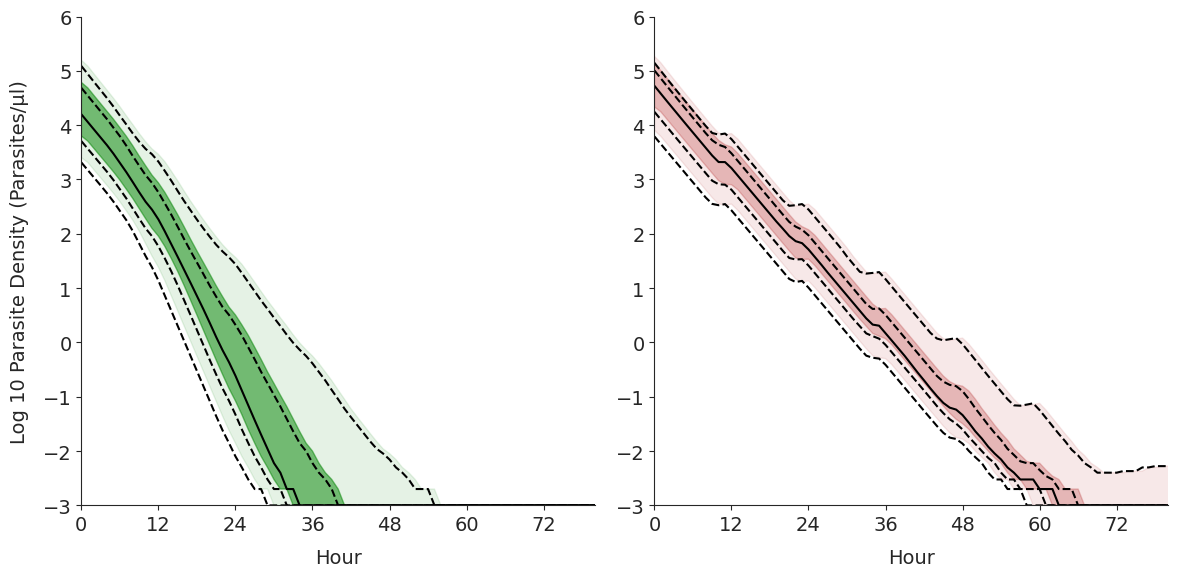

In [73]:
# Create subplots
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

colors = ["#B22222", "#98FF98"]
sns.set_palette(sns.color_palette(colors))

ax1 = sns.lineplot(ax=axes[0], x= df_weight_compiled_pandas['HOUR'], y= median_parasite_density_cleared_log, color="black")
sns.lineplot(ax=axes[0], x=df_weight_compiled_pandas['HOUR'], y=perc_05_parasite_density_cleared_log, color="black", linestyle='--')
sns.lineplot(ax=axes[0], x=df_weight_compiled_pandas['HOUR'], y=perc_25_parasite_density_cleared_log, color="black", linestyle='--')
sns.lineplot(ax=axes[0], x=df_weight_compiled_pandas['HOUR'], y=perc_75_parasite_density_cleared_log, color="black", linestyle='--')
sns.lineplot(ax=axes[0], x=df_weight_compiled_pandas['HOUR'], y=perc_95_parasite_density_cleared_log, color="black", linestyle='--')
axes[0].fill_between(np.arange(672),perc_25_parasite_density_cleared_log, perc_75_parasite_density_cleared_log, color="#008400", alpha=0.5)
axes[0].fill_between(np.arange(672),perc_05_parasite_density_cleared_log, perc_95_parasite_density_cleared_log, color="#008400", alpha=0.1)


sns.despine(ax=ax1)


ax1.set_xlim(0, 80)
#ax1.set_yticks(range(0, int(df_100_patients['PARASITEDENSITY'].max()) + 100, 1000))
ax1.set_ylim(-3, 6)
#Set x-axis label
ax1.set_xlabel('Hour', labelpad = 10)
#Set y-axis label
ax1.set_ylabel('Log 10 Parasite Density (Parasites/μl)', labelpad = 10)

# Set tick positions and labels for specific days
tick_positions = [0, 12.0, 24.0, 36.0, 48.0, 60.0, 72.0]  # Day 0, Day 7, Day 14, Day 28 in hours
tick_labels = ['0', '12', '24', '36','48', '60', '72']
ax1.set_xticks(tick_positions, tick_labels)
#Adding grid lines
# axes[0].grid(visible=True, which='major', color='black', linewidth=0.075)
# axes[0].grid(visible=True, which='minor', color='black', linewidth=0.075)
#Plot title
#ax1.set_title('Parasite Density in Patients Treated Successfully', fontsize = 10, pad = 20)


ax2 = sns.lineplot(ax=axes[1], x= df_weight_compiled_pandas['HOUR'], y= median_parasite_density_failed_log, color="black")
sns.lineplot(ax=axes[1], x=df_weight_compiled_pandas['HOUR'], y=perc_05_parasite_density_failed_log, color="black", linestyle='--')
sns.lineplot(ax=axes[1], x=df_weight_compiled_pandas['HOUR'], y=perc_25_parasite_density_failed_log, color="black", linestyle='--')
sns.lineplot(ax=axes[1], x=df_weight_compiled_pandas['HOUR'], y=perc_75_parasite_density_failed_log, color="black", linestyle='--')
sns.lineplot(ax=axes[1], x=df_weight_compiled_pandas['HOUR'], y=perc_95_parasite_density_failed_log, color="black", linestyle='--')
axes[1].fill_between(np.arange(672), perc_05_parasite_density_failed_log, perc_95_parasite_density_failed_log, color="#B22222", alpha=0.1)
axes[1].fill_between(np.arange(672),perc_25_parasite_density_failed_log, perc_75_parasite_density_failed_log, color="#B22222", alpha=0.25)   


sns.despine(ax=ax2)

ax2.set_xlim(0, 80)
ax2.set_ylim(-3, 6)
#Set x-axis label
ax2.set_xlabel('Hour', labelpad = 10)
#Set y-axis label
ax2.set_ylabel(None)
#ax2.set_ylabel('Log 10 Parasite Density (Parasites/μl)', labelpad = 10)
ax2.set_xticks(tick_positions, tick_labels)
#Adding grid lines 
# axes[1].grid(visible=True, which='major', color='black', linewidth=0.075)
# axes[1].grid(visible=True, which='minor', color='black', linewidth=0.075)
#Plot title
#ax2.set_title('Parasite Density in Patients Treated Successfully', fontsize = 10, pad = 20)
#ax2.text(7, 299, 'Parasite Density in Patients with Treatment Failure', fontsize = 10)




#Adding grid lines
# axes[2].grid(visible=True, which='major', color='black', linewidth=0.075)
# axes[2].grid(visible=True, which='minor', color='black', linewidth=0.075)

# Set common x-axis label
#fig.text(0.5, 0.04, 'Day', ha='center', va='center')

#Save plot
plt.savefig(f'{file_suffix}_log_03.svg', format='svg', )

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

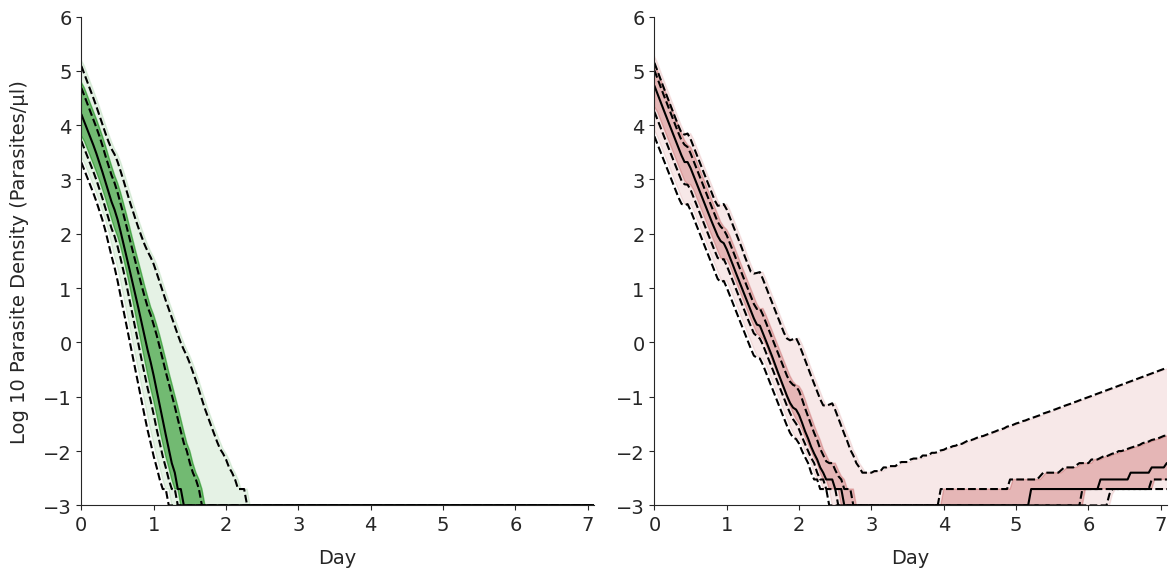

In [75]:
# Create subplots
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

colors = ["#B22222", "#98FF98"]
sns.set_palette(sns.color_palette(colors))

ax1 = sns.lineplot(ax=axes[0], x= df_weight_compiled_pandas['HOUR'], y= median_parasite_density_cleared_log, color="black")
sns.lineplot(ax=axes[0], x=df_weight_compiled_pandas['HOUR'], y=perc_05_parasite_density_cleared_log, color="black", linestyle='--')
sns.lineplot(ax=axes[0], x=df_weight_compiled_pandas['HOUR'], y=perc_25_parasite_density_cleared_log, color="black", linestyle='--')
sns.lineplot(ax=axes[0], x=df_weight_compiled_pandas['HOUR'], y=perc_75_parasite_density_cleared_log, color="black", linestyle='--')
sns.lineplot(ax=axes[0], x=df_weight_compiled_pandas['HOUR'], y=perc_95_parasite_density_cleared_log, color="black", linestyle='--')
axes[0].fill_between(np.arange(672),perc_25_parasite_density_cleared_log, perc_75_parasite_density_cleared_log, color="#008400", alpha=0.5)
axes[0].fill_between(np.arange(672),perc_05_parasite_density_cleared_log, perc_95_parasite_density_cleared_log, color="#008400", alpha=0.1)


sns.despine(ax=ax1)


ax1.set_xlim(0, 170)
#ax1.set_yticks(range(0, int(df_100_patients['PARASITEDENSITY'].max()) + 100, 1000))
ax1.set_ylim(-3, 6)
#Set x-axis label
ax1.set_xlabel('Day', labelpad = 10)
#Set y-axis label
ax1.set_ylabel('Log 10 Parasite Density (Parasites/μl)', labelpad = 10)

# Set tick positions and labels for specific days
# tick_positions = [0, 12.0, 24.0, 36.0, 48.0, 60.0, 72.0]  # Day 0, Day 7, Day 14, Day 28 in hours
# tick_labels = ['0', '12', '24', '36','48', '60', '72']
tick_positions = [0, 24.0, 48.0, 72.0, 96.0, 120.0, 144.0, 168.0]  # Day 0, Day 7, Day 14, Day 28 in hours
tick_labels = ['0', '1', '2', '3','4', '5', '6', '7']
ax1.set_xticks(tick_positions, tick_labels)
#Adding grid lines
# axes[0].grid(visible=True, which='major', color='black', linewidth=0.075)
# axes[0].grid(visible=True, which='minor', color='black', linewidth=0.075)
#Plot title
#ax1.set_title('Parasite Density in Patients Treated Successfully', fontsize = 10, pad = 20)


ax2 = sns.lineplot(ax=axes[1], x= df_weight_compiled_pandas['HOUR'], y= median_parasite_density_failed_log, color="black")
sns.lineplot(ax=axes[1], x=df_weight_compiled_pandas['HOUR'], y=perc_05_parasite_density_failed_log, color="black", linestyle='--')
sns.lineplot(ax=axes[1], x=df_weight_compiled_pandas['HOUR'], y=perc_25_parasite_density_failed_log, color="black", linestyle='--')
sns.lineplot(ax=axes[1], x=df_weight_compiled_pandas['HOUR'], y=perc_75_parasite_density_failed_log, color="black", linestyle='--')
sns.lineplot(ax=axes[1], x=df_weight_compiled_pandas['HOUR'], y=perc_95_parasite_density_failed_log, color="black", linestyle='--')
axes[1].fill_between(np.arange(672), perc_05_parasite_density_failed_log, perc_95_parasite_density_failed_log, color="#B22222", alpha=0.1)
axes[1].fill_between(np.arange(672),perc_25_parasite_density_failed_log, perc_75_parasite_density_failed_log, color="#B22222", alpha=0.25)   


sns.despine(ax=ax2)

ax2.set_xlim(0, 170)
ax2.set_ylim(-3, 6)
#Set x-axis label
ax2.set_xlabel('Day', labelpad = 10)
#Set y-axis label
ax2.set_ylabel(None)
#ax2.set_ylabel('Log 10 Parasite Density (Parasites/μl)', labelpad = 10)
ax2.set_xticks(tick_positions, tick_labels)
#Adding grid lines 
# axes[1].grid(visible=True, which='major', color='black', linewidth=0.075)
# axes[1].grid(visible=True, which='minor', color='black', linewidth=0.075)
#Plot title
#ax2.set_title('Parasite Density in Patients Treated Successfully', fontsize = 10, pad = 20)
#ax2.text(7, 299, 'Parasite Density in Patients with Treatment Failure', fontsize = 10)




#Adding grid lines
# axes[2].grid(visible=True, which='major', color='black', linewidth=0.075)
# axes[2].grid(visible=True, which='minor', color='black', linewidth=0.075)

# Set common x-axis label
#fig.text(0.5, 0.04, 'Day', ha='center', va='center')

#Save plot
plt.savefig(f'{file_suffix}_log_04.svg', format='svg', )

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [82]:
df_weight_compiled_cleared_art_wide = df_weight_compiled_cleared.pivot(index="HOUR", columns="PID", values="COMP2CONC_ARTEMETHER")
#df_weight_compiled_cleared_art_wide

df_weight_compiled_failed_art_wide = df_weight_compiled_failed.pivot(index="HOUR", columns="PID", values="COMP2CONC_ARTEMETHER")
#df_weight_compiled_failed_art_wide

In [84]:
# Calculate the median, 25th percentile, and 75th percentile for cleared and failed
median_art_conc_cleared = df_weight_compiled_cleared_art_wide.median(axis=1)
perc_05_art_conc_cleared = df_weight_compiled_cleared_art_wide.quantile(0.05,axis=1)
perc_25_art_conc_cleared = df_weight_compiled_cleared_art_wide.quantile(0.25,axis=1)
perc_75_art_conc_cleared = df_weight_compiled_cleared_art_wide.quantile(0.75,axis=1)
perc_95_art_conc_cleared = df_weight_compiled_cleared_art_wide.quantile(0.95,axis=1)


median_art_conc_failed = df_weight_compiled_failed_art_wide.median(axis=1)
perc_25_art_conc_failed = df_weight_compiled_failed_art_wide.quantile(0.25,axis=1)
perc_75_art_conc_failed = df_weight_compiled_failed_art_wide.quantile(0.75,axis=1)
perc_05_art_conc_failed = df_weight_compiled_failed_art_wide.quantile(0.05,axis=1)
perc_95_art_conc_failed = df_weight_compiled_failed_art_wide.quantile(0.95,axis=1)

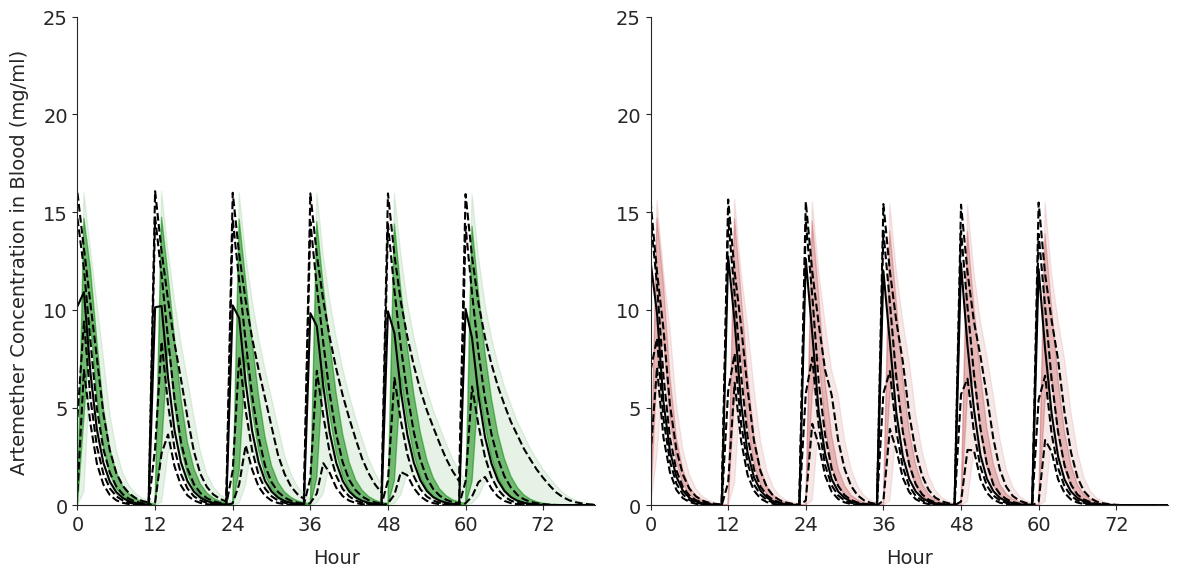

In [90]:
# Create subplots
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

colors = ["#B22222", "#98FF98"]
sns.set_palette(sns.color_palette(colors))

ax1 = sns.lineplot(ax=axes[0], x= df_weight_compiled_pandas['HOUR'], y= median_art_conc_cleared, color="black")
sns.lineplot(ax=axes[0], x=df_weight_compiled_pandas['HOUR'], y=perc_05_art_conc_cleared, color="black", linestyle='--')
sns.lineplot(ax=axes[0], x=df_weight_compiled_pandas['HOUR'], y=perc_25_art_conc_cleared, color="black", linestyle='--')
sns.lineplot(ax=axes[0], x=df_weight_compiled_pandas['HOUR'], y=perc_75_art_conc_cleared, color="black", linestyle='--')
sns.lineplot(ax=axes[0], x=df_weight_compiled_pandas['HOUR'], y=perc_95_art_conc_cleared, color="black", linestyle='--')
axes[0].fill_between(np.arange(672),perc_25_art_conc_cleared, perc_75_art_conc_cleared, color="#008400", alpha=0.5)
axes[0].fill_between(np.arange(672),perc_05_art_conc_cleared, perc_95_art_conc_cleared, color="#008400", alpha=0.1)


sns.despine(ax=ax1)


ax1.set_xlim(0, 80)
#ax1.set_yticks(range(0, int(df_100_patients['PARASITEDENSITY'].max()) + 100, 1000))
ax1.set_ylim(0, 25)
#Set x-axis label
ax1.set_xlabel('Hour', labelpad = 10)
#Set y-axis label
ax1.set_ylabel('Artemether Concentration in Blood (mg/ml)', labelpad = 10)

# Set tick positions and labels for specific days
tick_positions = [0, 12.0, 24.0, 36.0, 48.0, 60.0, 72.0]  # Day 0, Day 7, Day 14, Day 28 in hours
tick_labels = ['0', '12', '24', '36','48', '60', '72']
ax1.set_xticks(tick_positions, tick_labels)
#Adding grid lines
# axes[0].grid(visible=True, which='major', color='black', linewidth=0.075)
# axes[0].grid(visible=True, which='minor', color='black', linewidth=0.075)
#Plot title
#ax1.set_title('Parasite Density in Patients Treated Successfully', fontsize = 10, pad = 20)


ax2 = sns.lineplot(ax=axes[1], x= df_weight_compiled_pandas['HOUR'], y= median_art_conc_failed, color="black")
sns.lineplot(ax=axes[1], x=df_weight_compiled_pandas['HOUR'], y=perc_05_art_conc_failed, color="black", linestyle='--')
sns.lineplot(ax=axes[1], x=df_weight_compiled_pandas['HOUR'], y=perc_25_art_conc_failed, color="black", linestyle='--')
sns.lineplot(ax=axes[1], x=df_weight_compiled_pandas['HOUR'], y=perc_75_art_conc_failed, color="black", linestyle='--')
sns.lineplot(ax=axes[1], x=df_weight_compiled_pandas['HOUR'], y=perc_95_art_conc_failed, color="black", linestyle='--')
axes[1].fill_between(np.arange(672), perc_05_art_conc_failed, perc_95_art_conc_failed, color="#B22222", alpha=0.1)
axes[1].fill_between(np.arange(672),perc_25_art_conc_failed, perc_75_art_conc_failed, color="#B22222", alpha=0.25)   


sns.despine(ax=ax2)

ax2.set_xlim(0, 80)
ax2.set_ylim(0, 25)
#Set x-axis label
ax2.set_xlabel('Hour', labelpad = 10)
#Set y-axis label
ax2.set_ylabel(None)
#ax2.set_ylabel('Log 10 Parasite Density (Parasites/μl)', labelpad = 10)
ax2.set_xticks(tick_positions, tick_labels)
#Adding grid lines 
# axes[1].grid(visible=True, which='major', color='black', linewidth=0.075)
# axes[1].grid(visible=True, which='minor', color='black', linewidth=0.075)
#Plot title
#ax2.set_title('Parasite Density in Patients Treated Successfully', fontsize = 10, pad = 20)
#ax2.text(7, 299, 'Parasite Density in Patients with Treatment Failure', fontsize = 10)




#Adding grid lines
# axes[2].grid(visible=True, which='major', color='black', linewidth=0.075)
# axes[2].grid(visible=True, which='minor', color='black', linewidth=0.075)

# Set common x-axis label
#fig.text(0.5, 0.04, 'Day', ha='center', va='center')

#Save plot
plt.savefig(f'{file_suffix}_artemether_conc_72h.svg', format='svg', )

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [86]:
df_weight_compiled_cleared_lum_wide = df_weight_compiled_cleared.pivot(index="HOUR", columns="PID", values="COMP2CONC_LUM")
#df_weight_compiled_cleared_lum_wide

df_weight_compiled_failed_lum_wide = df_weight_compiled_failed.pivot(index="HOUR", columns="PID", values="COMP2CONC_LUM")
#df_weight_compiled_failed_lum_wide

In [87]:
# Calculate the median, 25th percentile, and 75th percentile for cleared and failed
median_lum_conc_cleared = df_weight_compiled_cleared_lum_wide.median(axis=1)
perc_05_lum_conc_cleared = df_weight_compiled_cleared_lum_wide.quantile(0.05,axis=1)
perc_25_lum_conc_cleared = df_weight_compiled_cleared_lum_wide.quantile(0.25,axis=1)
perc_75_lum_conc_cleared = df_weight_compiled_cleared_lum_wide.quantile(0.75,axis=1)
perc_95_lum_conc_cleared = df_weight_compiled_cleared_lum_wide.quantile(0.95,axis=1)


median_lum_conc_failed = df_weight_compiled_failed_lum_wide.median(axis=1)
perc_25_lum_conc_failed = df_weight_compiled_failed_lum_wide.quantile(0.25,axis=1)
perc_75_lum_conc_failed = df_weight_compiled_failed_lum_wide.quantile(0.75,axis=1)
perc_05_lum_conc_failed = df_weight_compiled_failed_lum_wide.quantile(0.05,axis=1)
perc_95_lum_conc_failed = df_weight_compiled_failed_lum_wide.quantile(0.95,axis=1)

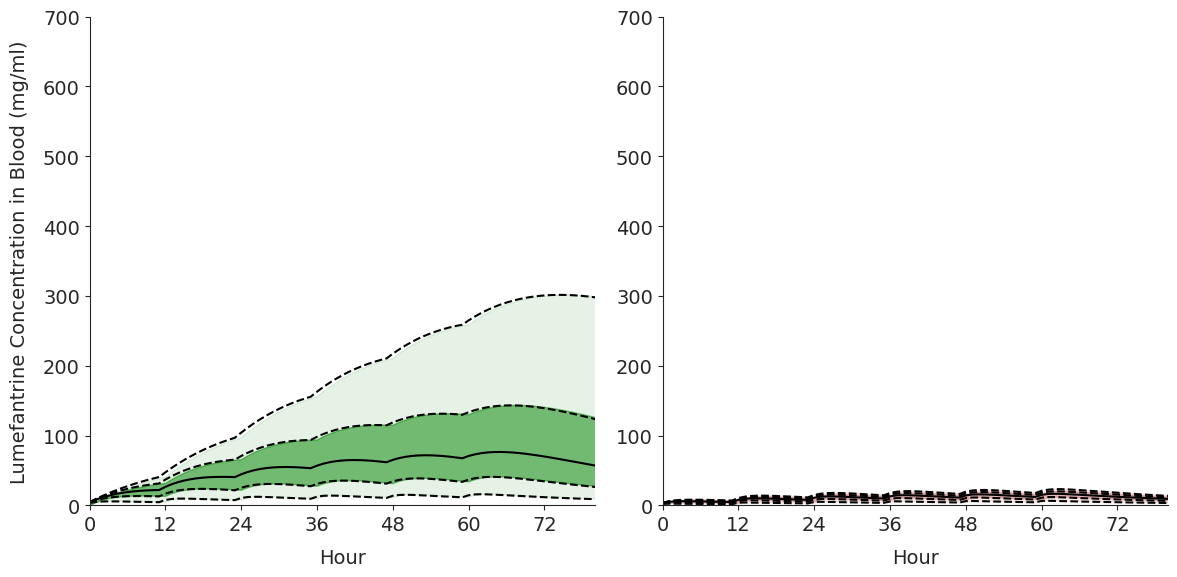

In [91]:
# Create subplots
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

colors = ["#B22222", "#98FF98"]
sns.set_palette(sns.color_palette(colors))

ax1 = sns.lineplot(ax=axes[0], x= df_weight_compiled_pandas['HOUR'], y= median_lum_conc_cleared, color="black")
sns.lineplot(ax=axes[0], x=df_weight_compiled_pandas['HOUR'], y=perc_05_lum_conc_cleared, color="black", linestyle='--')
sns.lineplot(ax=axes[0], x=df_weight_compiled_pandas['HOUR'], y=perc_25_lum_conc_cleared, color="black", linestyle='--')
sns.lineplot(ax=axes[0], x=df_weight_compiled_pandas['HOUR'], y=perc_75_lum_conc_cleared, color="black", linestyle='--')
sns.lineplot(ax=axes[0], x=df_weight_compiled_pandas['HOUR'], y=perc_95_lum_conc_cleared, color="black", linestyle='--')
axes[0].fill_between(np.arange(672),perc_25_lum_conc_cleared, perc_75_lum_conc_cleared, color="#008400", alpha=0.5)
axes[0].fill_between(np.arange(672),perc_05_lum_conc_cleared, perc_95_lum_conc_cleared, color="#008400", alpha=0.1)


sns.despine(ax=ax1)


ax1.set_xlim(0, 80)
#ax1.set_yticks(range(0, int(df_100_patients['PARASITEDENSITY'].max()) + 100, 1000))
ax1.set_ylim(0, 700)
#Set x-axis label
ax1.set_xlabel('Hour', labelpad = 10)
#Set y-axis label
ax1.set_ylabel('Lumefantrine Concentration in Blood (mg/ml)', labelpad = 10)

# Set tick positions and labels for specific days
tick_positions = [0, 12.0, 24.0, 36.0, 48.0, 60.0, 72.0]  # Day 0, Day 7, Day 14, Day 28 in hours
tick_labels = ['0', '12', '24', '36','48', '60', '72']
ax1.set_xticks(tick_positions, tick_labels)
#Adding grid lines
# axes[0].grid(visible=True, which='major', color='black', linewidth=0.075)
# axes[0].grid(visible=True, which='minor', color='black', linewidth=0.075)
#Plot title
#ax1.set_title('Parasite Density in Patients Treated Successfully', fontsize = 10, pad = 20)


ax2 = sns.lineplot(ax=axes[1], x= df_weight_compiled_pandas['HOUR'], y= median_lum_conc_failed, color="black")
sns.lineplot(ax=axes[1], x=df_weight_compiled_pandas['HOUR'], y=perc_05_lum_conc_failed, color="black", linestyle='--')
sns.lineplot(ax=axes[1], x=df_weight_compiled_pandas['HOUR'], y=perc_25_lum_conc_failed, color="black", linestyle='--')
sns.lineplot(ax=axes[1], x=df_weight_compiled_pandas['HOUR'], y=perc_75_lum_conc_failed, color="black", linestyle='--')
sns.lineplot(ax=axes[1], x=df_weight_compiled_pandas['HOUR'], y=perc_95_lum_conc_failed, color="black", linestyle='--')
axes[1].fill_between(np.arange(672), perc_05_lum_conc_failed, perc_95_lum_conc_failed, color="#B22222", alpha=0.1)
axes[1].fill_between(np.arange(672),perc_25_lum_conc_failed, perc_75_lum_conc_failed, color="#B22222", alpha=0.25)   


sns.despine(ax=ax2)

ax2.set_xlim(0, 80)
ax2.set_ylim(0, 700)
#Set x-axis label
ax2.set_xlabel('Hour', labelpad = 10)
#Set y-axis label
ax2.set_ylabel(None)
#ax2.set_ylabel('Log 10 Parasite Density (Parasites/μl)', labelpad = 10)
ax2.set_xticks(tick_positions, tick_labels)
#Adding grid lines 
# axes[1].grid(visible=True, which='major', color='black', linewidth=0.075)
# axes[1].grid(visible=True, which='minor', color='black', linewidth=0.075)
#Plot title
#ax2.set_title('Parasite Density in Patients Treated Successfully', fontsize = 10, pad = 20)
#ax2.text(7, 299, 'Parasite Density in Patients with Treatment Failure', fontsize = 10)




#Adding grid lines
# axes[2].grid(visible=True, which='major', color='black', linewidth=0.075)
# axes[2].grid(visible=True, which='minor', color='black', linewidth=0.075)

# Set common x-axis label
#fig.text(0.5, 0.04, 'Day', ha='center', va='center')

#Save plot
plt.savefig(f'{file_suffix}_lum_conc_72h.svg', format='svg', )

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

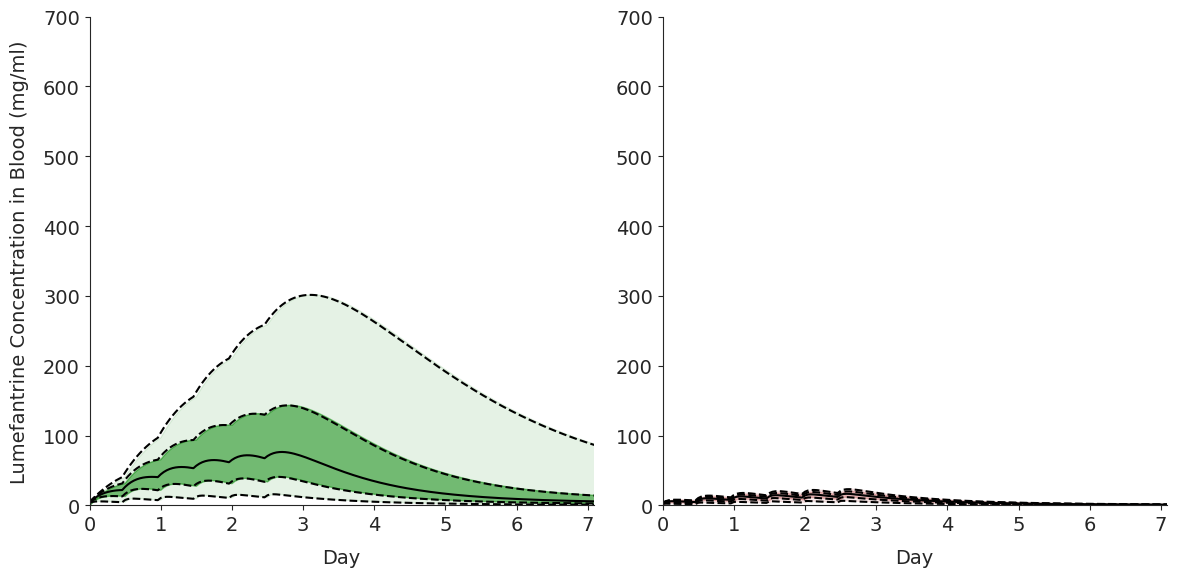

In [92]:
# Create subplots
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

colors = ["#B22222", "#98FF98"]
sns.set_palette(sns.color_palette(colors))

ax1 = sns.lineplot(ax=axes[0], x= df_weight_compiled_pandas['HOUR'], y= median_lum_conc_cleared, color="black")
sns.lineplot(ax=axes[0], x=df_weight_compiled_pandas['HOUR'], y=perc_05_lum_conc_cleared, color="black", linestyle='--')
sns.lineplot(ax=axes[0], x=df_weight_compiled_pandas['HOUR'], y=perc_25_lum_conc_cleared, color="black", linestyle='--')
sns.lineplot(ax=axes[0], x=df_weight_compiled_pandas['HOUR'], y=perc_75_lum_conc_cleared, color="black", linestyle='--')
sns.lineplot(ax=axes[0], x=df_weight_compiled_pandas['HOUR'], y=perc_95_lum_conc_cleared, color="black", linestyle='--')
axes[0].fill_between(np.arange(672),perc_25_lum_conc_cleared, perc_75_lum_conc_cleared, color="#008400", alpha=0.5)
axes[0].fill_between(np.arange(672),perc_05_lum_conc_cleared, perc_95_lum_conc_cleared, color="#008400", alpha=0.1)


sns.despine(ax=ax1)


ax1.set_xlim(0, 170)
#ax1.set_yticks(range(0, int(df_100_patients['PARASITEDENSITY'].max()) + 100, 1000))
ax1.set_ylim(0, 700)
#Set x-axis label
ax1.set_xlabel('Day', labelpad = 10)
#Set y-axis label
ax1.set_ylabel('Lumefantrine Concentration in Blood (mg/ml)', labelpad = 10)

# Set tick positions and labels for specific days
tick_positions = [0, 24.0, 48.0, 72.0, 96.0, 120.0, 144.0, 168.0]  
tick_labels = ['0', '1', '2', '3','4', '5', '6', '7']
ax1.set_xticks(tick_positions, tick_labels)
#Adding grid lines
# axes[0].grid(visible=True, which='major', color='black', linewidth=0.075)
# axes[0].grid(visible=True, which='minor', color='black', linewidth=0.075)
#Plot title
#ax1.set_title('Parasite Density in Patients Treated Successfully', fontsize = 10, pad = 20)


ax2 = sns.lineplot(ax=axes[1], x= df_weight_compiled_pandas['HOUR'], y= median_lum_conc_failed, color="black")
sns.lineplot(ax=axes[1], x=df_weight_compiled_pandas['HOUR'], y=perc_05_lum_conc_failed, color="black", linestyle='--')
sns.lineplot(ax=axes[1], x=df_weight_compiled_pandas['HOUR'], y=perc_25_lum_conc_failed, color="black", linestyle='--')
sns.lineplot(ax=axes[1], x=df_weight_compiled_pandas['HOUR'], y=perc_75_lum_conc_failed, color="black", linestyle='--')
sns.lineplot(ax=axes[1], x=df_weight_compiled_pandas['HOUR'], y=perc_95_lum_conc_failed, color="black", linestyle='--')
axes[1].fill_between(np.arange(672), perc_05_lum_conc_failed, perc_95_lum_conc_failed, color="#B22222", alpha=0.1)
axes[1].fill_between(np.arange(672),perc_25_lum_conc_failed, perc_75_lum_conc_failed, color="#B22222", alpha=0.25)   


sns.despine(ax=ax2)

ax2.set_xlim(0, 170)
ax2.set_ylim(0, 700)
#Set x-axis label
ax2.set_xlabel('Day', labelpad = 10)
#Set y-axis label
ax2.set_ylabel(None)
#ax2.set_ylabel('Log 10 Parasite Density (Parasites/μl)', labelpad = 10)
ax2.set_xticks(tick_positions, tick_labels)
#Adding grid lines 
# axes[1].grid(visible=True, which='major', color='black', linewidth=0.075)
# axes[1].grid(visible=True, which='minor', color='black', linewidth=0.075)
#Plot title
#ax2.set_title('Parasite Density in Patients Treated Successfully', fontsize = 10, pad = 20)
#ax2.text(7, 299, 'Parasite Density in Patients with Treatment Failure', fontsize = 10)




#Adding grid lines
# axes[2].grid(visible=True, which='major', color='black', linewidth=0.075)
# axes[2].grid(visible=True, which='minor', color='black', linewidth=0.075)

# Set common x-axis label
#fig.text(0.5, 0.04, 'Day', ha='center', va='center')

#Save plot
plt.savefig(f'{file_suffix}_lum_conc_7days.svg', format='svg', )

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

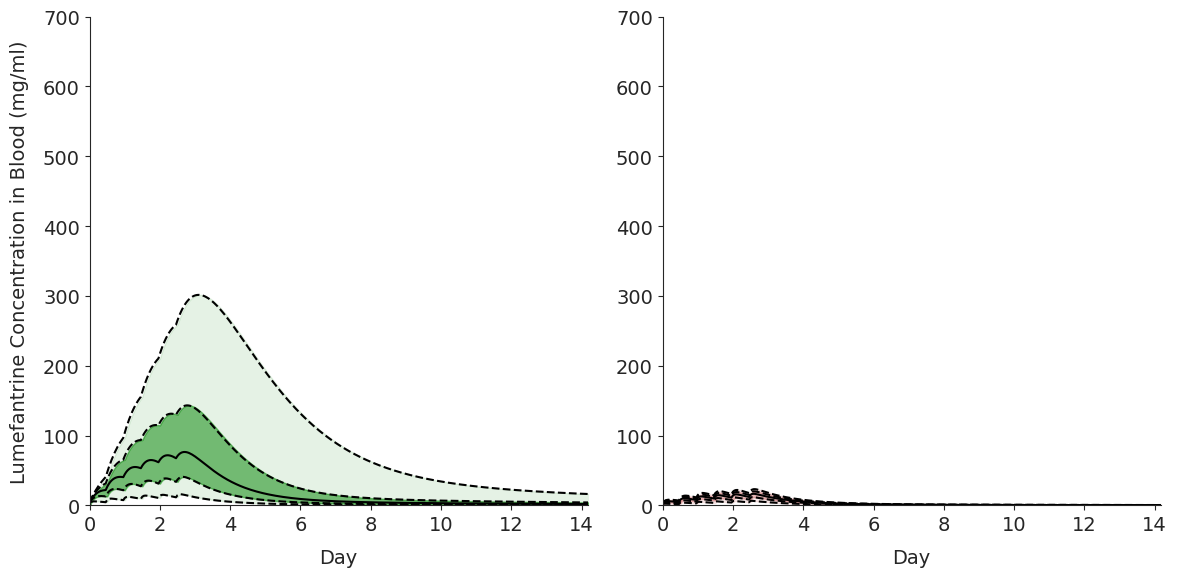

In [93]:
# Create subplots
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

colors = ["#B22222", "#98FF98"]
sns.set_palette(sns.color_palette(colors))

ax1 = sns.lineplot(ax=axes[0], x= df_weight_compiled_pandas['HOUR'], y= median_lum_conc_cleared, color="black")
sns.lineplot(ax=axes[0], x=df_weight_compiled_pandas['HOUR'], y=perc_05_lum_conc_cleared, color="black", linestyle='--')
sns.lineplot(ax=axes[0], x=df_weight_compiled_pandas['HOUR'], y=perc_25_lum_conc_cleared, color="black", linestyle='--')
sns.lineplot(ax=axes[0], x=df_weight_compiled_pandas['HOUR'], y=perc_75_lum_conc_cleared, color="black", linestyle='--')
sns.lineplot(ax=axes[0], x=df_weight_compiled_pandas['HOUR'], y=perc_95_lum_conc_cleared, color="black", linestyle='--')
axes[0].fill_between(np.arange(672),perc_25_lum_conc_cleared, perc_75_lum_conc_cleared, color="#008400", alpha=0.5)
axes[0].fill_between(np.arange(672),perc_05_lum_conc_cleared, perc_95_lum_conc_cleared, color="#008400", alpha=0.1)


sns.despine(ax=ax1)


ax1.set_xlim(0, 340)
#ax1.set_yticks(range(0, int(df_100_patients['PARASITEDENSITY'].max()) + 100, 1000))
ax1.set_ylim(0, 700)
#Set x-axis label
ax1.set_xlabel('Day', labelpad = 10)
#Set y-axis label
ax1.set_ylabel('Lumefantrine Concentration in Blood (mg/ml)', labelpad = 10)

# Set tick positions and labels for specific days
tick_positions = [0, 48.0, 96.0, 144.0, 192.0, 240.0, 288.0, 336.0]  
tick_labels = ['0', '2', '4', '6','8', '10', '12', '14']
ax1.set_xticks(tick_positions, tick_labels)
#Adding grid lines
# axes[0].grid(visible=True, which='major', color='black', linewidth=0.075)
# axes[0].grid(visible=True, which='minor', color='black', linewidth=0.075)
#Plot title
#ax1.set_title('Parasite Density in Patients Treated Successfully', fontsize = 10, pad = 20)


ax2 = sns.lineplot(ax=axes[1], x= df_weight_compiled_pandas['HOUR'], y= median_lum_conc_failed, color="black")
sns.lineplot(ax=axes[1], x=df_weight_compiled_pandas['HOUR'], y=perc_05_lum_conc_failed, color="black", linestyle='--')
sns.lineplot(ax=axes[1], x=df_weight_compiled_pandas['HOUR'], y=perc_25_lum_conc_failed, color="black", linestyle='--')
sns.lineplot(ax=axes[1], x=df_weight_compiled_pandas['HOUR'], y=perc_75_lum_conc_failed, color="black", linestyle='--')
sns.lineplot(ax=axes[1], x=df_weight_compiled_pandas['HOUR'], y=perc_95_lum_conc_failed, color="black", linestyle='--')
axes[1].fill_between(np.arange(672), perc_05_lum_conc_failed, perc_95_lum_conc_failed, color="#B22222", alpha=0.1)
axes[1].fill_between(np.arange(672),perc_25_lum_conc_failed, perc_75_lum_conc_failed, color="#B22222", alpha=0.25)   


sns.despine(ax=ax2)

ax2.set_xlim(0, 340)
ax2.set_ylim(0, 700)
#Set x-axis label
ax2.set_xlabel('Day', labelpad = 10)
#Set y-axis label
ax2.set_ylabel(None)
#ax2.set_ylabel('Log 10 Parasite Density (Parasites/μl)', labelpad = 10)
ax2.set_xticks(tick_positions, tick_labels)
#Adding grid lines 
# axes[1].grid(visible=True, which='major', color='black', linewidth=0.075)
# axes[1].grid(visible=True, which='minor', color='black', linewidth=0.075)
#Plot title
#ax2.set_title('Parasite Density in Patients Treated Successfully', fontsize = 10, pad = 20)
#ax2.text(7, 299, 'Parasite Density in Patients with Treatment Failure', fontsize = 10)




#Adding grid lines
# axes[2].grid(visible=True, which='major', color='black', linewidth=0.075)
# axes[2].grid(visible=True, which='minor', color='black', linewidth=0.075)

# Set common x-axis label
#fig.text(0.5, 0.04, 'Day', ha='center', va='center')

#Save plot
plt.savefig(f'{file_suffix}_lum_conc_14days.svg', format='svg', )

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

<br>
<br>

<br>

## pfcrt K76: 92.5%
### ```pmax_artemether```: 0.9998653531
### ```ec50_lum```: 121.5372211838

In [10]:
# Function to run a single simulation for a given weight value

def run_single_weight_simulation(weight):
    start_time = time.monotonic()
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "5000",
        "--pmax_artemether", "0.9998653531",
        "--ec50_lum", "121.54",
        "--weight", str(weight)
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split() for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ARTEMETHER", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        if df_weight['PARASITEDENSITY'].isna().any():
            failed_treatment_count = np.nan
        else:
            failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0]
        
        total_patients = df_weight['PID'].nunique()
        
        if total_patients == 0 or np.isnan(failed_treatment_count): 
            efficacy = np.nan
        else:
            percentage_failed = (failed_treatment_count / total_patients) * 100
            efficacy = (100 - percentage_failed)
            if np.isnan(efficacy):
                efficacy = np.nan
        
        end_time = time.monotonic()
        today = datetime.date.today()
        print("\nToday's date: ", today, "\n")
        print("Length of simulation: ", datetime.timedelta(seconds=end_time - start_time), "\n")

        return efficacy, df_weight, failed_treatment_count
        
    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure

In [ ]:
# Define the weight values to use
weight_values = [15, 20, 30, 40, 50]
#weight_values = [10]

# File suffix for saving results
folder = "pfcrt_K76"
file_suffix = "pfcrt_K76"

for weight in weight_values:

        efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)
        
        # Save the DataFrame to a pickle file
        df_weight.to_pickle(f"df_weight_{weight}kg_{file_suffix}.pyobj")

        # Save the DataFrame to a CSV file
        df_weight.to_csv(f"df_weight_{weight}kg_{file_suffix}.csv", index=False)

        print(f"\nThe failed treatment count for weight {weight}kg is:", failed_treatment_count)
        print(f"\nThe percentage efficacy for weight {weight}kg is:", efficacy, "\n")


In [13]:
# Function to run a single simulation for a given weight value

def run_single_weight_simulation(weight):
    start_time = time.monotonic()
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "1000",
        #"--pmax_artemether", "0.9998653531",
        "--pmax_artemether", "0.9999994",
        "--ec50_lum", "72.789",
        "--weight", str(weight)
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split() for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ARTEMETHER", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        if df_weight['PARASITEDENSITY'].isna().any():
            failed_treatment_count = np.nan
        else:
            failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0]
        
        total_patients = df_weight['PID'].nunique()
        
        if total_patients == 0 or np.isnan(failed_treatment_count): 
            efficacy = np.nan
        else:
            percentage_failed = (failed_treatment_count / total_patients) * 100
            efficacy = (100 - percentage_failed)
            if np.isnan(efficacy):
                efficacy = np.nan
        
        end_time = time.monotonic()
        today = datetime.date.today()
        print("\nToday's date: ", today, "\n")
        print("Length of simulation: ", datetime.timedelta(seconds=end_time - start_time), "\n")

        return efficacy, df_weight, failed_treatment_count
        
    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure

In [14]:
# Define the weight values to use
weight_values = [10, 20, 30, 40, 50, 60, 70]
#weight_values = [10]

# File suffix for saving results
file_suffix = "AL_max_efficacy_02"

for weight in weight_values:

        efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)
        
        # Save the DataFrame to a pickle file
        df_weight.to_pickle(f"df_weight_{weight}kg_{file_suffix}.pyobj")

        # Save the DataFrame to a CSV file
        df_weight.to_csv(f"df_weight_{weight}kg_{file_suffix}.csv", index=False)

        print(f"\nThe failed treatment count for weight {weight}kg is:", failed_treatment_count)
        print(f"\nThe percentage efficacy for weight {weight}kg is:", efficacy, "\n")



Today's date:  2025-06-16 

Length of simulation:  0:00:27.658156 


The failed treatment count for weight 10kg is: 444

The percentage efficacy for weight 10kg is: 55.6 


Today's date:  2025-06-16 

Length of simulation:  0:00:24.343979 


The failed treatment count for weight 20kg is: 34

The percentage efficacy for weight 20kg is: 96.6 


Today's date:  2025-06-16 

Length of simulation:  0:00:26.068924 


The failed treatment count for weight 30kg is: 1

The percentage efficacy for weight 30kg is: 99.9 


Today's date:  2025-06-16 

Length of simulation:  0:00:23.408044 


The failed treatment count for weight 40kg is: 0

The percentage efficacy for weight 40kg is: 100.0 


Today's date:  2025-06-16 

Length of simulation:  0:00:25.333082 


The failed treatment count for weight 50kg is: 0

The percentage efficacy for weight 50kg is: 100.0 


Today's date:  2025-06-16 

Length of simulation:  0:00:26.143833 


The failed treatment count for weight 60kg is: 0

The percentage effic

In [15]:
# Load the dataframes
# Calculate the efficacy for each weight group

failed_treatment_count = []
efficacy = []
df_weight_compiled = []

for weight in [10, 20, 30, 40, 50]:
    # Load the dataframe
    df_weight = pd.read_pickle(f"df_weight_{weight}kg_{file_suffix}.pyobj")
    # Calculate the efficacy
    failed_treatment_count.append(df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0])
    total_patients = df_weight['PID'].nunique()
    efficacy.append((1 - (failed_treatment_count[-1] / total_patients)) * 100 if total_patients > 0 else np.nan)
    # Append the dataframe to the list
    df_weight_compiled.append(df_weight)
# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Weight': [10, 20, 30, 40, 50],
    'Failed Treatment Count': failed_treatment_count,
    'Efficacy': efficacy
})

# Save the results to a CSV file
results_df.to_csv(f"efficacy_results_compiled_{file_suffix}.csv", index=False)
# Save the results to a pickle file
results_df.to_pickle(f"efficacy_results_compiled_{file_suffix}.pyobj")
# Print the results
print("\nEfficacy Results:")
print(results_df)
 


Efficacy Results:
   Weight  Failed Treatment Count  Efficacy
0      10                     444      55.6
1      20                      34      96.6
2      30                       1      99.9
3      40                       0     100.0
4      50                       0     100.0


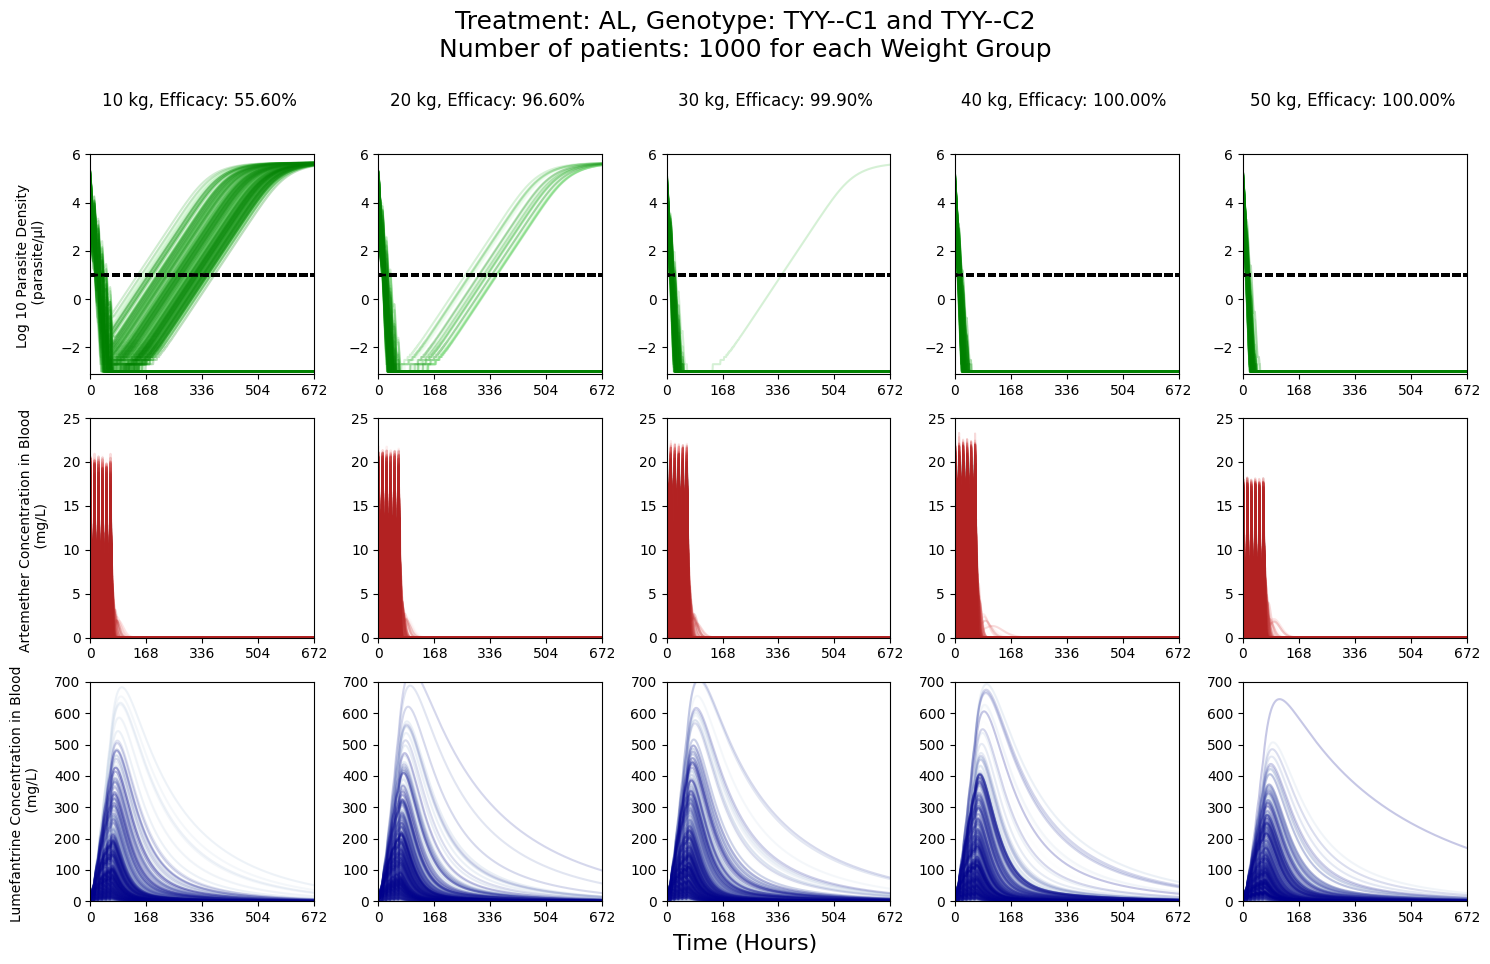

In [16]:
import math
from matplotlib.colors import LinearSegmentedColormap

if len(df_weight_compiled) >= 5:
    df_dict = {10: df_weight_compiled[0], 20: df_weight_compiled[1], 30: df_weight_compiled[2], 40: df_weight_compiled[3], 50: df_weight_compiled[4]}
else:
    print("Error: df_weight_compiled does not have enough elements.")

# Create a 4x3 subplot (3 variables, 5 weightgroups)
fig, ax = plt.subplots(3, 5, figsize=(15, 10), sharex=True, sharey=False)

# Define colormaps for each plot
green_cmap = LinearSegmentedColormap.from_list("green_cmap", ["white", "lightgreen", "green"])  # Softer green for Parasite Density
red_cmap = LinearSegmentedColormap.from_list("red_cmap", ["white", "lightcoral", "firebrick"])  # Softer red for Artemether
blue_cmap = LinearSegmentedColormap.from_list("blue_cmap", ["white", "lightsteelblue", "darkblue"])  # Softer blue for Lumefantrine

# Iterate over weight groups
for i, weight in enumerate([10, 20, 30, 40, 50]):
    df_weight = df_dict[weight]  # Get the correct dataframe
    num_pids = len(df_weight['PID'].unique())  # Number of unique PIDs
    norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize colormap

    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid].copy()
        df_pid['LOG10_PARASITEDENSITY'] = np.log10(df_pid['PARASITEDENSITY'] + 0.001)
        color = green_cmap(norm(j))
        ax[0, i].plot(df_pid['HOUR'], df_pid['LOG10_PARASITEDENSITY'], color=color, alpha=0.25)
        ax[0, i].set_ylim(-3.1, 6)  # Set y-axis limits for Parasite Density
        ax[0, i].axhline(y=np.log10(10), color='black', linestyle='--') 

  
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = red_cmap(norm(j))
        ax[1, i].plot(df_pid['HOUR'], df_pid['COMP2CONC_ARTEMETHER'], color=color, alpha=0.25)
        ax[1, i].set_ylim(0, 25)
        ax[2, i].set_yticks(range(0, 30, 5)) 

    # Plot Lumefantrine Concentration (Row 3) with blue colormap
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = blue_cmap(norm(j))
        ax[2, i].plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)
        ax[2, i].set_ylim(0, 700)
        ax[2, i].set_yticks(range(0, 800, 100))  
    

    # Set x-axis limits
    for j in range(3):  # Iterate over rows (0, 1, 2)
        ax[j, i].set_xlim(0, 672)
        ax[j, i].set_xticks(range(0, 673, 168))

    # Set row labels on the top row
    ax[0, i].set_title(f'{weight} kg, Efficacy: {results_df[results_df["Weight"] == weight]["Efficacy"].values[0]:.2f}% \n ', fontsize=12, pad=20)

# Set **row titles** (only for the leftmost column)
row_titles = ["Log 10 Parasite Density \n (parasite/μl)", "Artemether Concentration in Blood \n (mg/L)", "Lumefantrine Concentration in Blood \n (mg/L)"]
for j in range(3):
    ax[j, 0].set_ylabel(row_titles[j], fontsize=10, rotation=90, labelpad=10)

# Set x-ticks for all subplots
for i in range(3):  
    for j in range(5):
        ax[i, j].tick_params(labelbottom=True)

fig.text(0.5, 0.04, 'Time (Hours)', ha='center', fontsize=16)

fig.suptitle(f"Treatment: AL, Genotype: TYY--C1 and TYY--C2\nNumber of patients: {num_pids} for each Weight Group", fontsize=18)

plt.tight_layout(rect=[0, 0.05, 1, 0.98])  # Adjust layout to fit common x-label
plt.savefig(f"df_weight_efficacy_{file_suffix}.png")
plt.show()


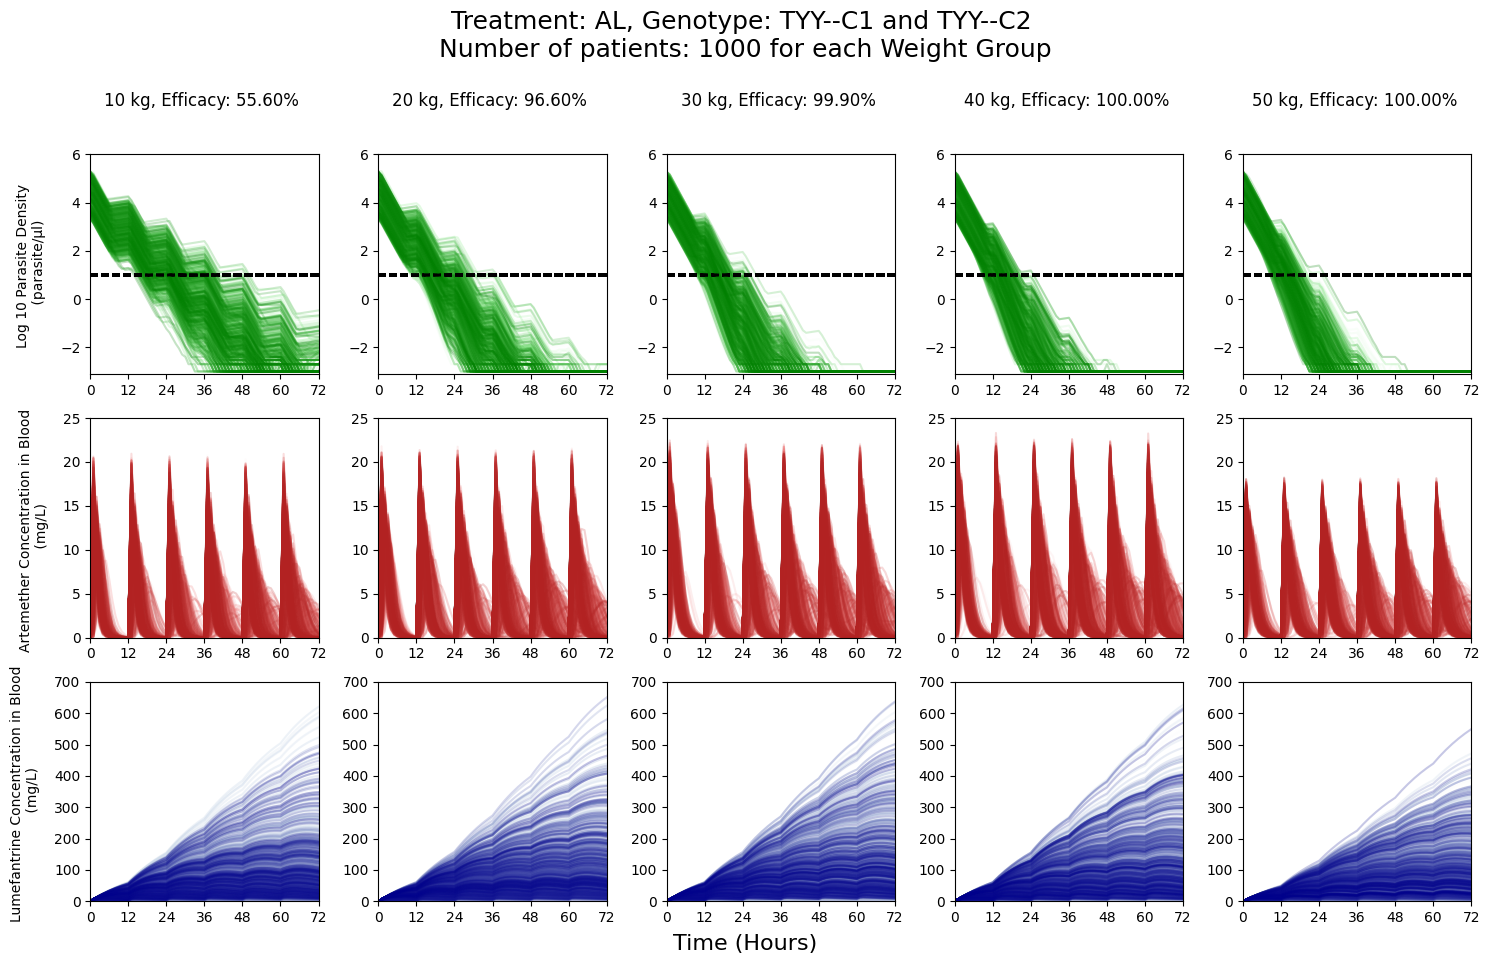

In [17]:
import math
from matplotlib.colors import LinearSegmentedColormap

if len(df_weight_compiled) >= 5:
    df_dict = {10: df_weight_compiled[0], 20: df_weight_compiled[1], 30: df_weight_compiled[2], 40: df_weight_compiled[3], 50: df_weight_compiled[4]}
else:
    print("Error: df_weight_compiled does not have enough elements.")

# Create a 4x3 subplot (3 variables, 5 weightgroups)
fig, ax = plt.subplots(3, 5, figsize=(15, 10), sharex=True, sharey=False)

# Define colormaps for each plot
green_cmap = LinearSegmentedColormap.from_list("green_cmap", ["white", "lightgreen", "green"])  # Softer green for Parasite Density
red_cmap = LinearSegmentedColormap.from_list("red_cmap", ["white", "lightcoral", "firebrick"])  # Softer red for Artemether
blue_cmap = LinearSegmentedColormap.from_list("blue_cmap", ["white", "lightsteelblue", "darkblue"])  # Softer blue for Lumefantrine

# Iterate over weight groups
for i, weight in enumerate([10, 20, 30, 40, 50]):
    df_weight = df_dict[weight]  # Get the correct dataframe
    num_pids = len(df_weight['PID'].unique())  # Number of unique PIDs
    norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize colormap

    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid].copy()
        df_pid['LOG10_PARASITEDENSITY'] = np.log10(df_pid['PARASITEDENSITY'] + 0.001)
        color = green_cmap(norm(j))
        ax[0, i].plot(df_pid['HOUR'], df_pid['LOG10_PARASITEDENSITY'], color=color, alpha=0.25)
        ax[0, i].set_ylim(-3.1, 6)  # Set y-axis limits for Parasite Density
        ax[0, i].axhline(y=np.log10(10), color='black', linestyle='--') 

  
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = red_cmap(norm(j))
        ax[1, i].plot(df_pid['HOUR'], df_pid['COMP2CONC_ARTEMETHER'], color=color, alpha=0.25)
        ax[1, i].set_ylim(0, 25)
        ax[2, i].set_yticks(range(0, 30, 5)) 

    # Plot Lumefantrine Concentration (Row 3) with blue colormap
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = blue_cmap(norm(j))
        ax[2, i].plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)
        ax[2, i].set_ylim(0, 700)
        ax[2, i].set_yticks(range(0, 800, 100))  
    

    # Set x-axis limits
    for j in range(3):  # Iterate over rows (0, 1, 2)
        ax[j, i].set_xlim(0, 72)
        ax[j, i].set_xticks(range(0, 73, 12))

    # Set row labels on the top row
    ax[0, i].set_title(f'{weight} kg, Efficacy: {results_df[results_df["Weight"] == weight]["Efficacy"].values[0]:.2f}% \n ', fontsize=12, pad=20)

# Set **row titles** (only for the leftmost column)
row_titles = ["Log 10 Parasite Density \n (parasite/μl)", "Artemether Concentration in Blood \n (mg/L)", "Lumefantrine Concentration in Blood \n (mg/L)"]
for j in range(3):
    ax[j, 0].set_ylabel(row_titles[j], fontsize=10, rotation=90, labelpad=10)

# Set x-ticks for all subplots
for i in range(3):  
    for j in range(5):
        ax[i, j].tick_params(labelbottom=True)

fig.text(0.5, 0.04, 'Time (Hours)', ha='center', fontsize=16)

fig.suptitle(f"Treatment: AL, Genotype: TYY--C1 and TYY--C2 \nNumber of patients: {num_pids} for each Weight Group", fontsize=18)

plt.tight_layout(rect=[0, 0.05, 1, 0.98])  # Adjust layout to fit common x-label
plt.savefig(f"df_weight_efficacy_{file_suffix}_72h.png")
plt.show()
